# Leios simulation analysis at tag `leios-2025w24`

## Load packages

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## TPS experiment

In [2]:
label <- "Rust simulator, mini-mainnet, 10 slot/stage, 328 kB/IB maximum, 1.5 EB/stage, multiple shards"

### Analysis of lifecycles and efficiencies

#### Read the lifecycle results

In [3]:
lifecycle <- fread("results/tps/lifecycle.csv.gz", stringsAsFactors=TRUE)
lifecycle[, `Kind`:=factor(`Kind`, levels=c("RB", "EB", "IB", "TX"))]
lifecycle[, `TPS`:=factor(paste(`TPS`, "tx/s"), levels=paste(c(1,3,10,30,100,300,1000), "tx/s"))]
lifecycle %>% summary

 Simulator            TPS         Kind             Item           Size [B]     
 Rust:357209   1 tx/s   :   798   RB:   261   0      :     6   Min.   :     7  
               3 tx/s   :  2123   EB:   721   1      :     6   1st Qu.:   406  
               10 tx/s  :  9084   IB: 36937   10     :     6   Median :   943  
               30 tx/s  : 20050   TX:319290   100    :     6   Mean   :  3178  
               100 tx/s : 92530               101    :     6   3rd Qu.:  2203  
               300 tx/s :232624               102    :     6   Max.   :327982  
               1000 tx/s:     0               (Other):357173                   
   References     Created [s]        To IB [s]        To EB [s]     
 Min.   : 0.00   Min.   :  0.001   Min.   : 61.13   Min.   : 30.07  
 1st Qu.: 1.00   1st Qu.:210.218   1st Qu.:273.13   1st Qu.:290.07  
 Median : 1.00   Median :364.979   Median :424.13   Median :440.07  
 Mean   : 1.57   Mean   :366.554   Mean   :424.98   Mean   :445.65  
 3rd Qu.: 1.00 

#### Range of transaction injection

In [4]:
txFirst <- 60
txLast <- 660
txWindow <- txLast - txFirst

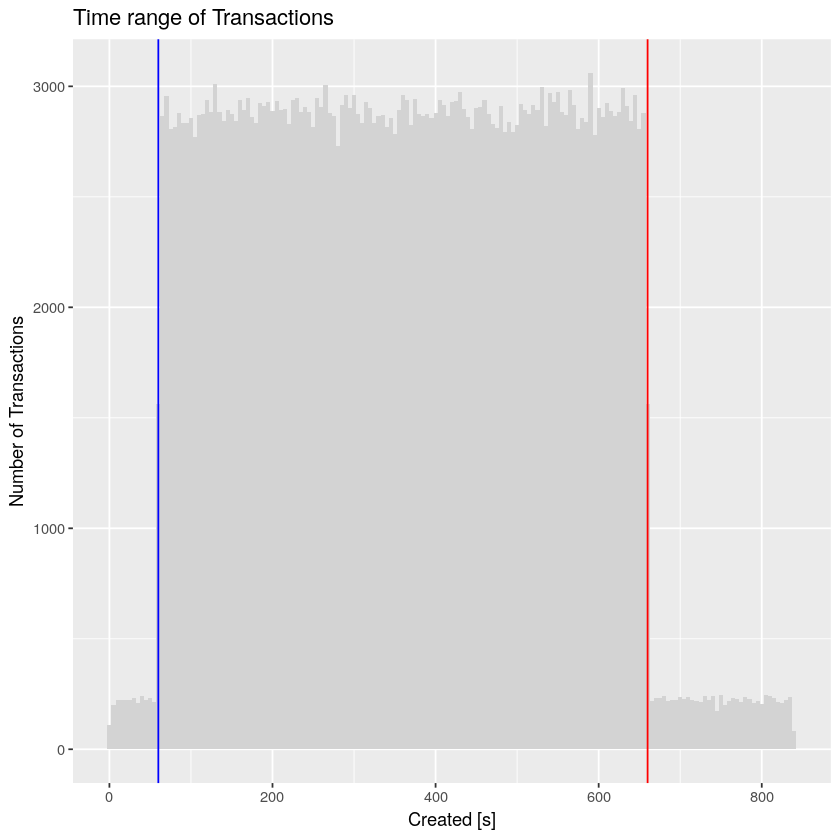

In [5]:
ggplot(lifecycle, aes(x=`Created [s]`)) +
    geom_histogram(binwidth=5, fill="lightgray") +
    geom_vline(xintercept=txFirst, color="blue") +
    geom_vline(xintercept=txLast, color="red") +
    ylab("Number of Transactions") +
    ggtitle("Time range of Transactions")

#### Actual TPS

In [6]:
lifecycle[`Kind` == "TX" & `Created [s]` >= txFirst & `Created [s]` <= txLast, .(`Actual TPS`=.N / txWindow), .(`Design TPS`=`TPS`)]

Design TPS,Actual TPS
<fct>,<dbl>
1 tx/s,1.031667
10 tx/s,10.600000
3 tx/s,3.130000
100 tx/s,112.005000
30 tx/s,31.793333
300 tx/s,373.590000


#### Check that the IB rate is sufficient for

In [7]:
lifecycle[`Kind` == "TX", .(`Size [IB/s]`=sum(`Size [B]`)/196608/3600), .(`TPS`)][
    data.table(`TPS`=c("1 tx/s", "3 tx/s", "10 tx/s", "30 tx/s", "100 tx/s", "300 tx/s"), `IB rate [IB/s]`=3*c(0.015, 0.045, 0.15, 0.45, 1.5, 4.5)),
    on="TPS"
][, .(
      `TPS`,
      `Size [IB/s]`,
      `IB rate [IB/s]`,
      `Okay?`=`Size [IB/s]`<=`IB rate [IB/s]`
)]

TPS,Size [IB/s],IB rate [IB/s],Okay?
<chr>,<dbl>,<dbl>,<lgl>
1 tx/s,0.001472460,0.045,TRUE
3 tx/s,0.004669325,0.135,TRUE
10 tx/s,0.015193127,0.450,TRUE
30 tx/s,0.045695808,1.350,TRUE
100 tx/s,0.161358387,4.500,TRUE
300 tx/s,0.536100276,13.500,TRUE


#### Size of persisted data

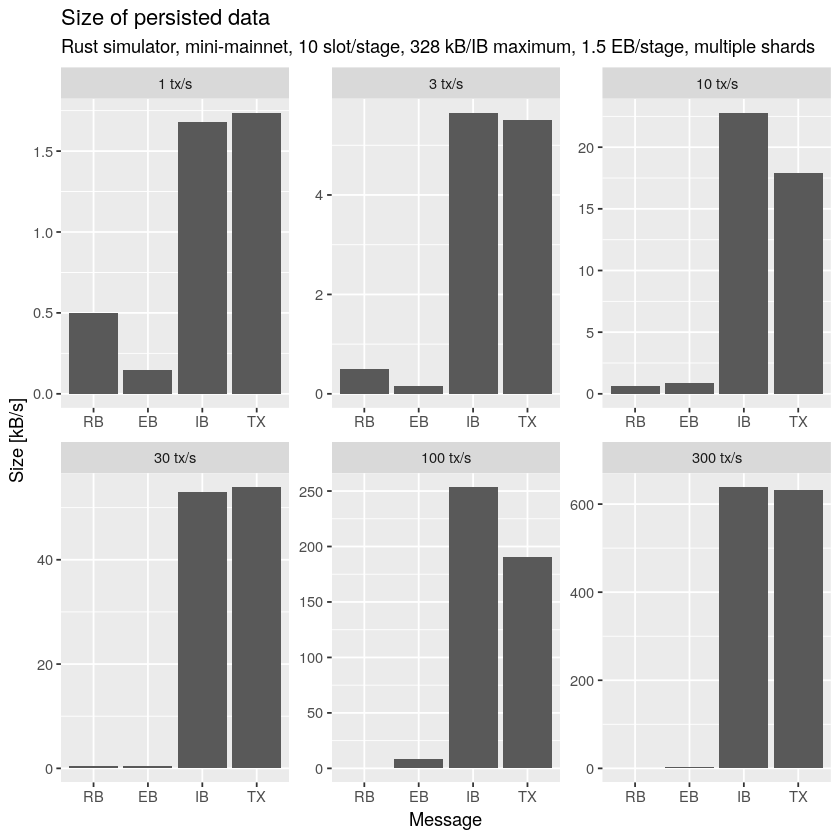

In [8]:
ggplot(
    lifecycle[, .(`Size [kB/s]`=sum(`Size [B]`)/1e3/600), .(`Message`=`Kind`, `TPS`)],
    aes(x=`Message`, y=`Size [kB/s]`)
) + geom_bar(stat="identity") +
    facet_wrap(`TPS` ~ ., scales="free") +
    ggtitle("Size of persisted data", subtitle=label)

In [9]:
ggsave("plots/tps/sizes.png", units="in", dpi=150, width=8, height=6)

In [10]:
ggsave("plots/tps/sizes.svg", units="in", dpi=150, width=8, height=6)

#### Spatial efficiency

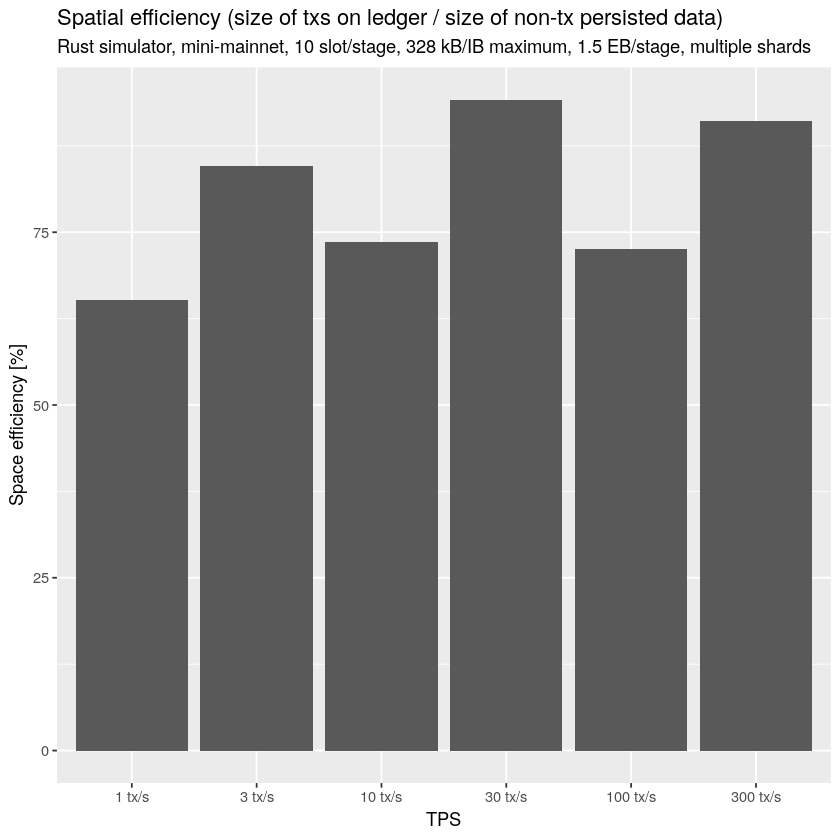

In [11]:
ggplot(
    lifecycle[
        `Kind` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`TPS`)
    ][
        lifecycle[
            `Kind` != "TX", 
            .(`Non-tx size [B]`=sum(as.numeric(`Size [B]`))), 
            .(`TPS`)
        ],
        on=c("TPS")
    ][, .(`TPS`, `Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`)],
    aes(x=`TPS`, y=`Space efficiency [%]`)
) +
    geom_bar(stat="identity") +
    ggtitle("Spatial efficiency (size of txs on ledger / size of non-tx persisted data)", label)

In [12]:
ggsave("plots/tps/spatial-efficiency.png", units="in", dpi=150, width=8, height=6)

In [13]:
ggsave("plots/tps/spatial-efficiency.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach the ledger

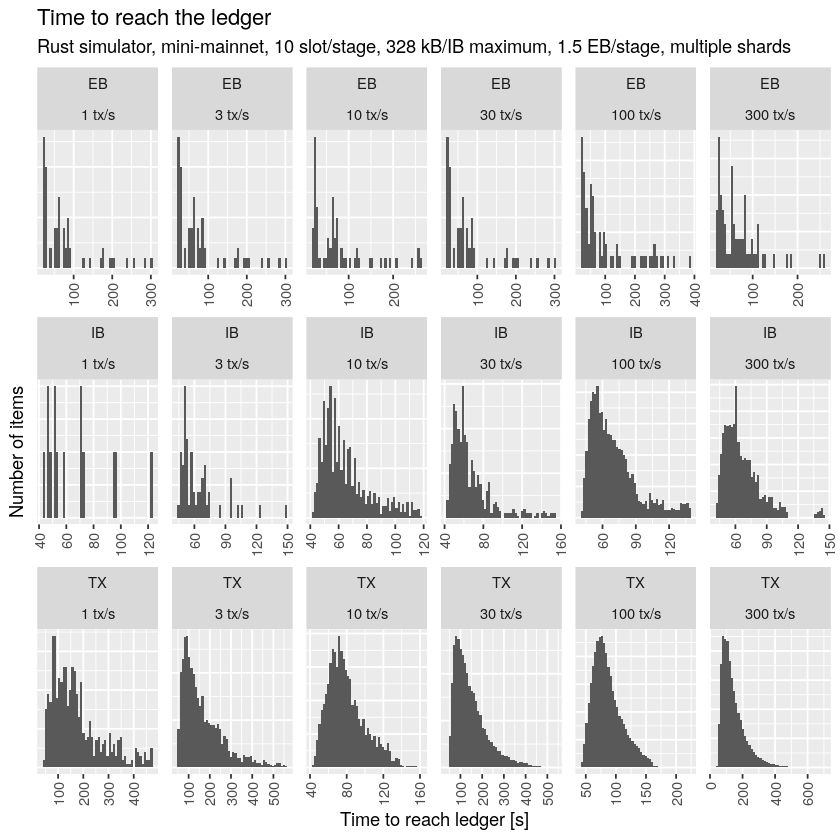

In [14]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB", "EB") & 
        !is.na(`To RB [s]`) & 
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
        .(`Kind`, `TPS`)
    ],
    aes(x=`Time to reach ledger [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(`Kind` ~ `TPS`, scales="free", ncol=6) +
    ylab("Number of items") +
    ggtitle("Time to reach the ledger", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [15]:
ggsave("plots/tps/reach-rb.png", units="in", dpi=150, width=8, height=6)

In [16]:
ggsave("plots/tps/reach-rb.svg", units="in", dpi=150, width=8, height=6)

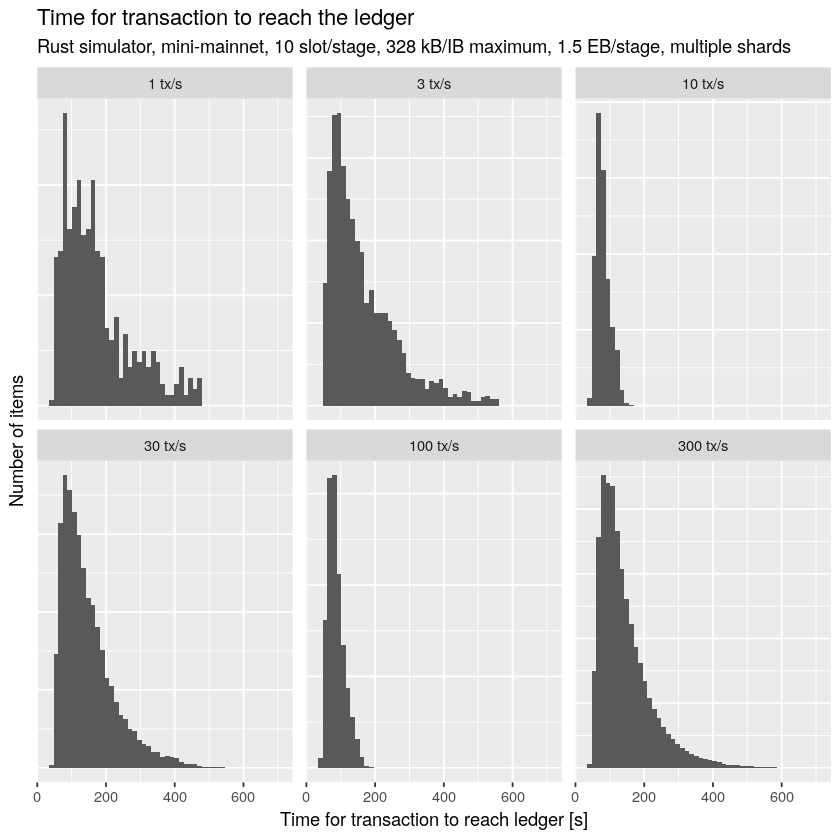

In [17]:
ggplot(
    lifecycle[
        `Kind` == "TX" & 
        !is.na(`To RB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
        .(`Kind`, `TPS`)
    ],
    aes(x=`Time to reach ledger [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(. ~ `TPS`, scales="free_y", ncol=3) +
    xlab("Time for transaction to reach ledger [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach the ledger", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [18]:
ggsave("plots/tps/reach-rb-tx.png", units="in", dpi=150, width=8, height=6)

In [19]:
ggsave("plots/tps/reach-rb-tx.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach an EB

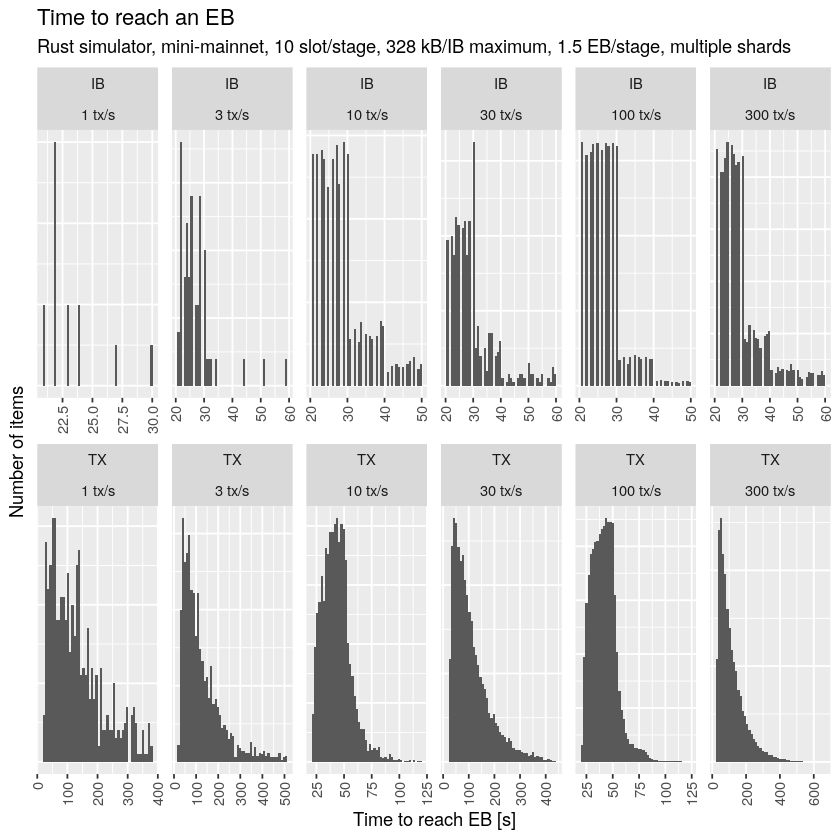

In [20]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB") & 
        !is.na(`To EB [s]`) & 
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach EB [s]`=`To EB [s]`-`Created [s]`), 
        .(`Kind`, `TPS`)
    ],
    aes(x=`Time to reach EB [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(`Kind` ~ `TPS`, scales="free", ncol=6) +
    ylab("Number of items") +
    ggtitle("Time to reach an EB", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [21]:
ggsave("plots/tps/reach-eb.png", units="in", dpi=150, width=8, height=6)

In [22]:
ggsave("plots/tps/reach-eb.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach an IB

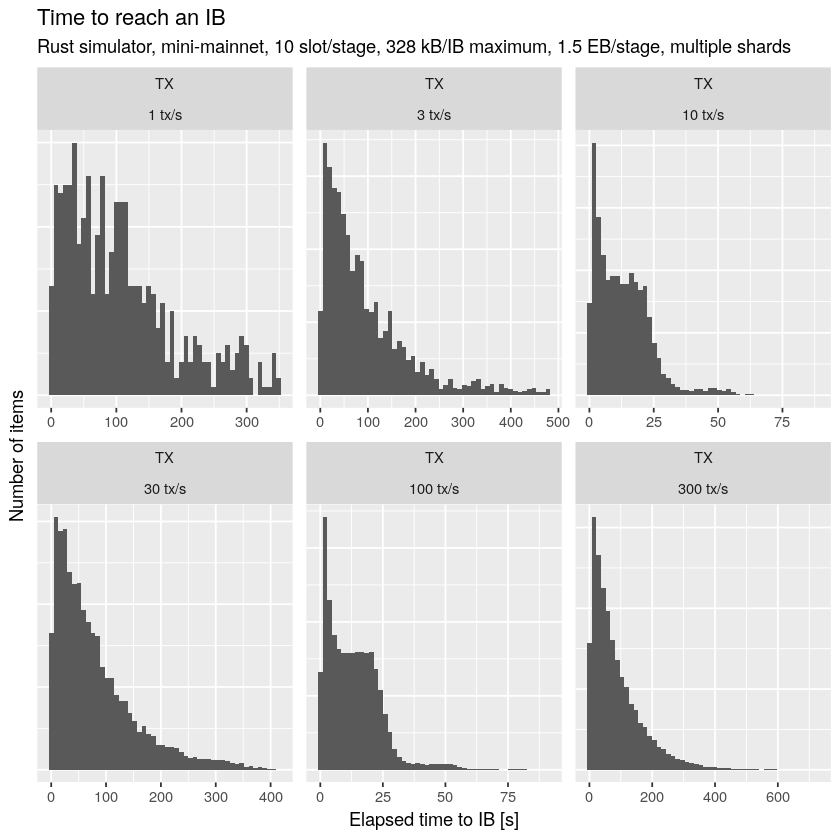

In [23]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX") & 
        !is.na(`To IB [s]`) & 
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Elapsed time to IB [s]`=`To IB [s]`-`Created [s]`), 
        .(`Kind`, `TPS`)],
    aes(x=`Elapsed time to IB [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(`Kind` ~ `TPS`, scales="free", ncol=3) +
    ylab("Number of items") +
    ggtitle("Time to reach an IB", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [24]:
ggsave("plots/tps/reach-ib.png", units="in", dpi=150, width=8, height=6)

In [25]:
ggsave("plots/tps/reach-ib.svg", units="in", dpi=150, width=8, height=6)

#### Number of references

A *reference* is one of the following:

- A transaction is included in an IB.
- An IB is referenced by an EB.
- An EB is referenced by another EB.

In an efficient Leios, the number of references for each data item would be one.

- *Zero references* indicates that the item was not used.
- *Two or more references* indicates that duplication has occurred.

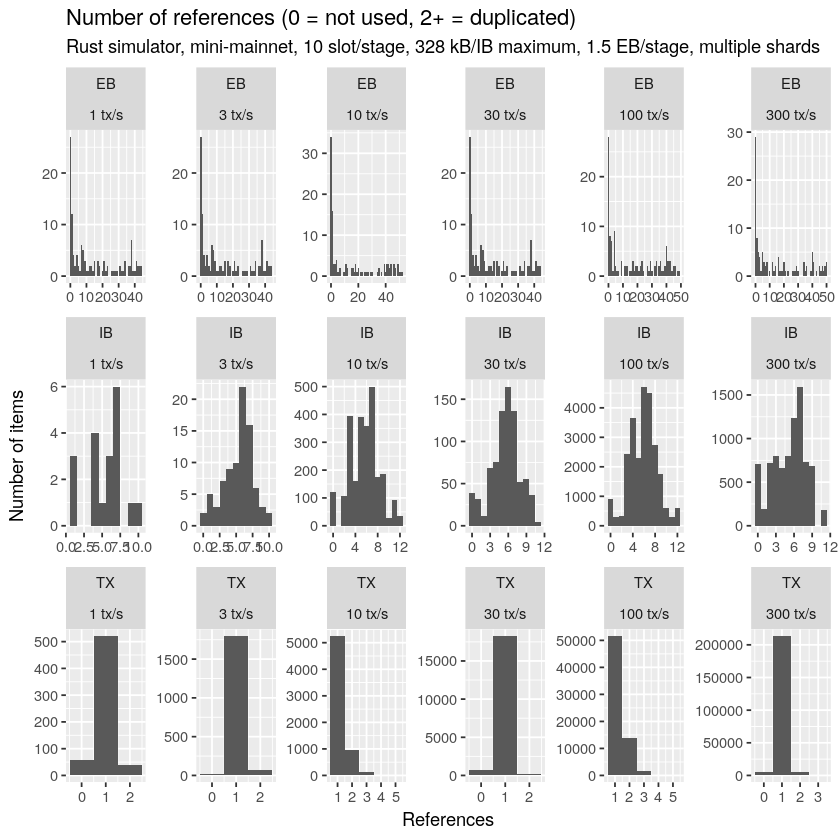

In [26]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB", "EB")
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_wrap(`Kind` ~ `TPS`, scales="free", ncol=6) +
    ylab("Number of items") +
    ggtitle("Number of references (0 = not used, 2+ = duplicated)", label)

In [27]:
ggsave("plots/tps/references.png", units="in", dpi=150, width=8, height=6)

In [28]:
ggsave("plots/tps/references.svg", units="in", dpi=150, width=8, height=6)

#### Temporal efficiency

In [29]:
toElapsed <- function(created, toRb, inRb) {
    if (!is.na(toRb))
        toRb - created
    else if (!is.na(inRb))
        inRb - created
    else
        NA
}

In [30]:
outcomes <- lifecycle[
    `Kind` == "TX",
    .(
        `Submitted [minute]`=factor(ceiling(`Created [s]`/60)), 
        `Time to reach ledger [s]`=mapply(toElapsed, `Created [s]`, `To RB [s]`, `In RB [s]`)
    ), .(
        `TPS`
    )
][order(`TPS`, `Submitted [minute]`, `Time to reach ledger [s]`)]

In [31]:
totals <- outcomes[, .(`Total`=.N, `Lost`=sum(is.na(`Time to reach ledger [s]`))), .(`TPS`, `Submitted [minute]`)]

#### Transactions reaching the ledger

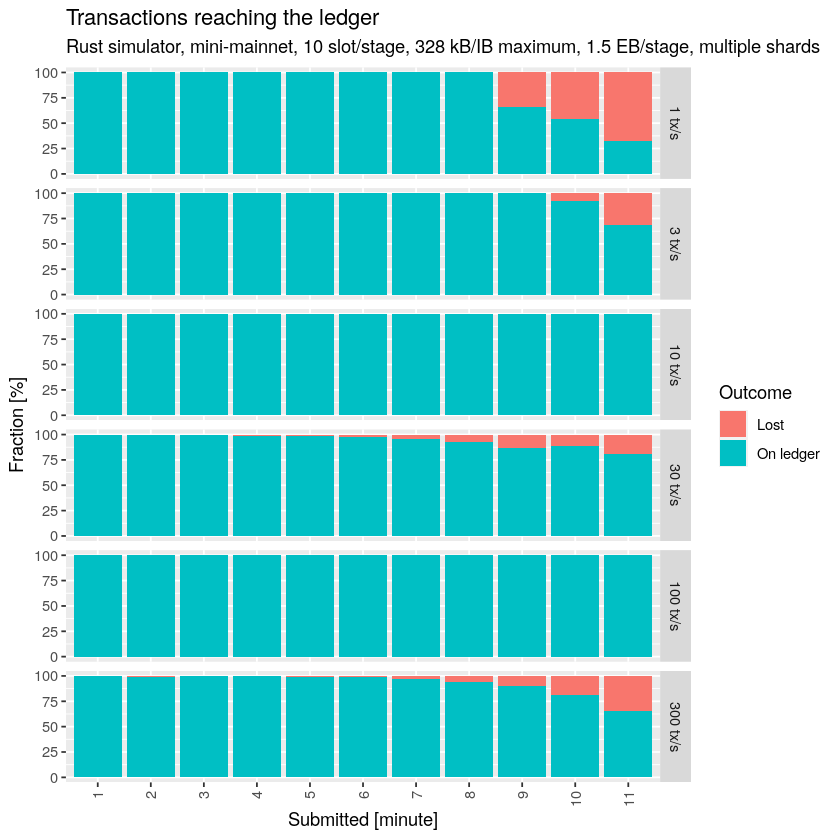

In [32]:
ggplot(
    melt(
        totals[, .(`On ledger`=1-`Lost`/`Total`, `Lost`=`Lost`/`Total`), .(`TPS`, `Submitted [minute]`)],
        id.vars=c("TPS", "Submitted [minute]"),
        variable.name="Outcome",
        value.name="Fraction"
    )[, .(
        `TPS`, 
        `Submitted [minute]`, 
        `Outcome`=factor(`Outcome`,levels=c("Lost","On ledger")), 
        `Fraction [%]`=100*`Fraction`
    )],
    aes(x=`Submitted [minute]`, y=`Fraction [%]`, fill=`Outcome`)
) +
    geom_bar(stat="identity") +
    facet_grid(`TPS` ~ .) +
    ggtitle("Transactions reaching the ledger", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [33]:
ggsave("plots/tps/temporal-efficiency-bar.png", units="in", dpi=150, width=8, height=6)

In [34]:
ggsave("plots/tps/temporal-efficiency-bar.svg", units="in", dpi=150, width=8, height=6)

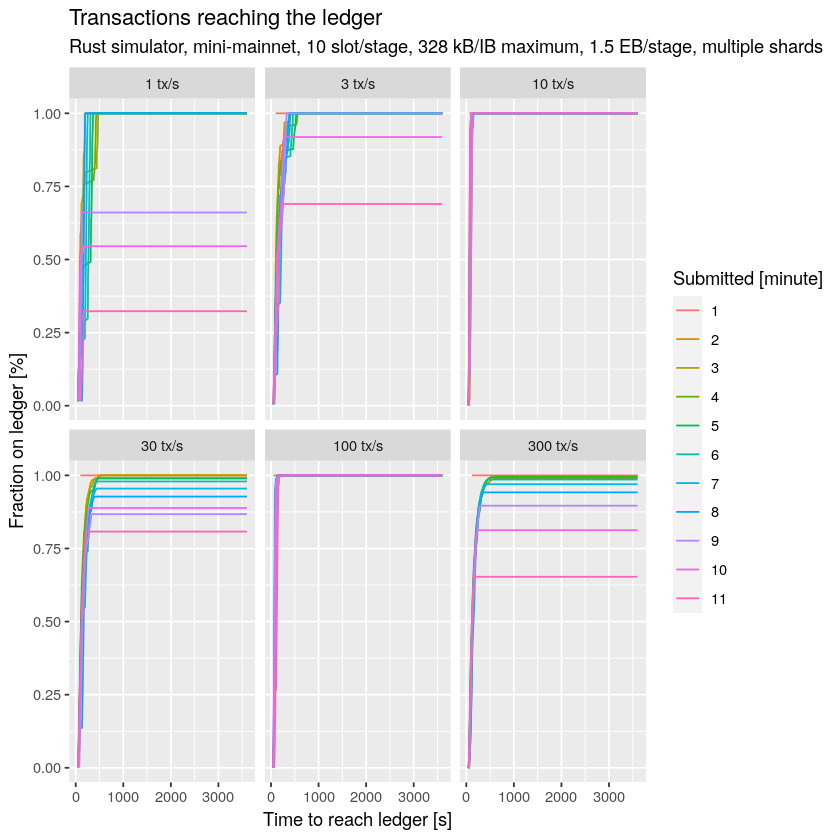

In [35]:
ggplot(
    rbind(
        totals[
            outcomes[!is.na(`Time to reach ledger [s]`), .(`Cumulative total`=1:length(`Time to reach ledger [s]`), `Time to reach ledger [s]`), .(`TPS`, `Submitted [minute]`)],
            on=c("TPS", "Submitted [minute]")
        ][,
            .(`Time to reach ledger [s]`, `Fraction on ledger [%]`=`Cumulative total`/`Total`),
            .(`TPS`, `Submitted [minute]`)
        ],
        totals[, .(`Fraction on ledger [%]`=1-`Lost`/`Total`, `Time to reach ledger [s]`=3600), .(`TPS`, `Submitted [minute]`)]
    )[`Submitted [minute]` != 0],
    aes(x=`Time to reach ledger [s]`, y=`Fraction on ledger [%]`, color=`Submitted [minute]`)
) +
    geom_line() +
    facet_wrap(`TPS` ~ .) +
    ggtitle("Transactions reaching the ledger", label)

In [36]:
ggsave("plots/tps/temporal-efficiency-timeseries.png", units="in", dpi=150, width=8, height=6)

In [37]:
ggsave("plots/tps/temporal-efficiency-timeseries.svg", units="in", dpi=150, width=8, height=6)

#### Release memory

In [38]:
rm(lifecycle, outcomes, totals)

### Resource usage

In [39]:
resources <- fread("results/tps/resources.csv.gz", stringsAsFactors=TRUE)
resources %>% summary

 Simulator        TPS            Node        Egress [B]    Disk [B]      
 Rust:4500   Min.   :  1   node-0  :   6   Min.   :0    Min.   :      0  
             1st Qu.:  3   node-1  :   6   1st Qu.:0    1st Qu.:      0  
             Median : 20   node-10 :   6   Median :0    Median :      0  
             Mean   : 74   node-100:   6   Mean   :0    Mean   : 132032  
             3rd Qu.:100   node-101:   6   3rd Qu.:0    3rd Qu.:      0  
             Max.   :300   node-102:   6   Max.   :0    Max.   :3346242  
                           (Other) :4464                                 
 Total CPU [s]     Maximum CPU [s/s]
 Min.   :  26.78   Min.   :0.5875   
 1st Qu.:  33.47   1st Qu.:0.9156   
 Median : 141.74   Median :0.9253   
 Mean   : 467.21   Mean   :1.5107   
 3rd Qu.: 975.00   3rd Qu.:2.4228   
 Max.   :1494.85   Max.   :3.2149   
                                    

In [ ]:
ggplot(
    resources[, .(`TX/s`=factor(`TPS`), `Node`, `Nodal egress [MB/s]`=`Egress [B]`/txWindow/1e6)], 
    aes(x=`TX/s`, y=`Nodal egress [MB/s]`)
) +
    geom_violin() +
    ggtitle("Network", label)

In [ ]:
ggsave("plots/tps/network.png", units="in", dpi=150, width=9.5, height=5.5)

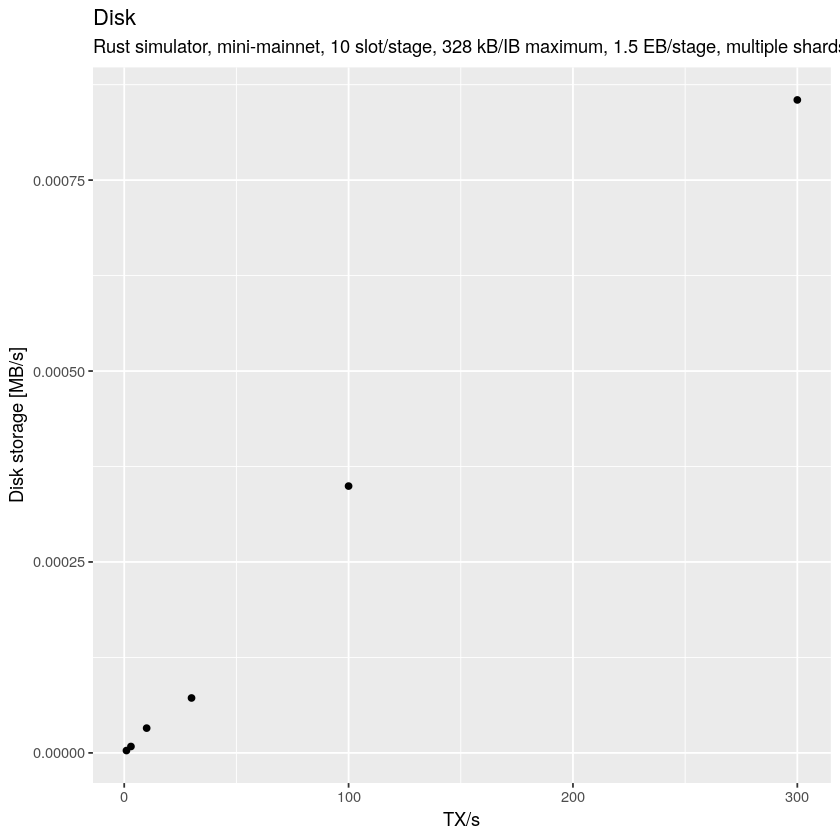

In [40]:
ggplot(
    resources[, .(`Disk storage [MB/s]`=mean(`Disk [B]`)/txWindow/1e6), .(`TX/s`=`TPS`)],
    aes(x=`TX/s`, y=`Disk storage [MB/s]`)
) +
    geom_point() +
    ggtitle("Disk", label)

In [41]:
ggsave("plots/tps/disk.png", units="in", dpi=150, width=9.5, height=5.5)

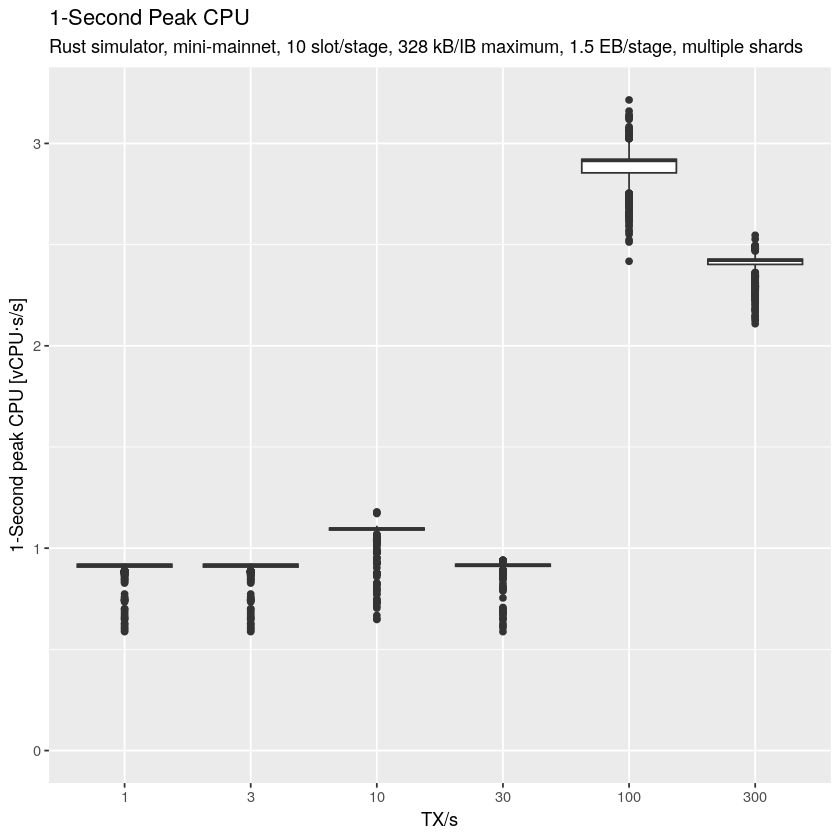

In [42]:
ggplot(
    resources[, .(`Node`, `TX/s`=factor(`TPS`), `1-Second peak CPU [vCPU⋅s/s]`=`Maximum CPU [s/s]`)], 
    aes(x=`TX/s`, y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    ggtitle("1-Second Peak CPU", label)

In [43]:
ggsave("plots/tps/cpu-peak.png", units="in", dpi=150, width=9.5, height=5.5)

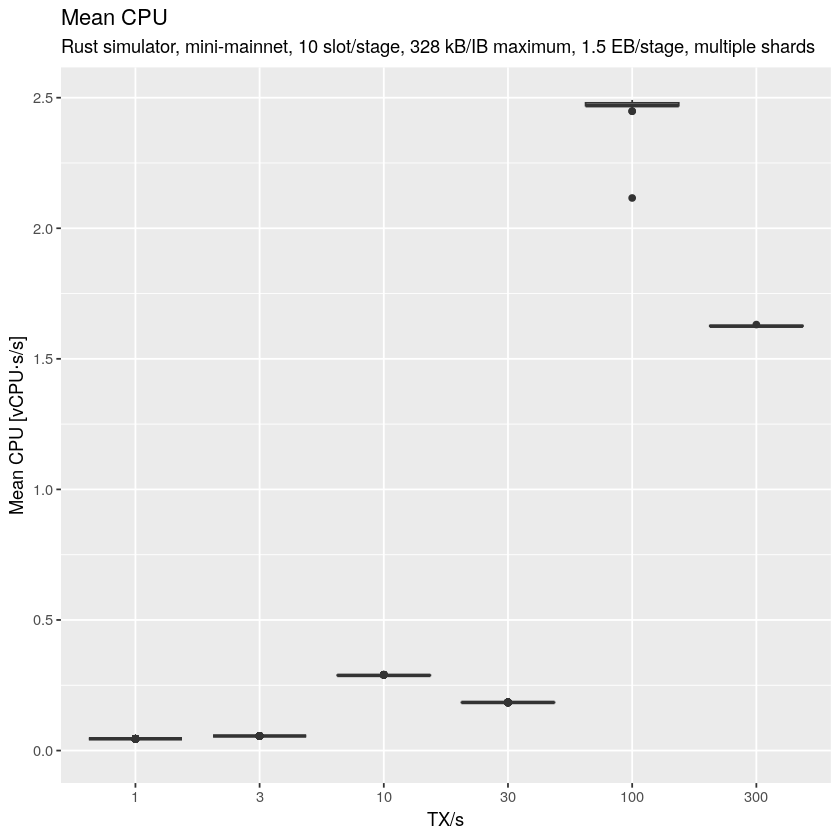

In [44]:
ggplot(
    resources[, .(`TX/s`=factor(`TPS`), `Node`, `Mean CPU [vCPU⋅s/s]`=`Total CPU [s]`/txWindow
        )
    ], aes(x=`TX/s`, y=`Mean CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    ggtitle("Mean CPU", label)

In [45]:
ggsave("plots/tps/cpu-mean.png", units="in", dpi=150, width=9.5, height=5.5)

#### Release memory

In [46]:
rm(resources)

### Receipt of messages

#### Read results

In [47]:
receipts <- fread("results/tps/receipts.csv.gz", stringsAsFactors=TRUE)
receipts %>% summary

 Simulator             TPS        Kind                     Item          
 Rust:319279154   Min.   :  1.0   EB:   540029   100-node-100:     7490  
                  1st Qu.:100.0   IB: 27655264   100-node-562:     6741  
                  Median :300.0   RB:   188739   100-node-596:     6741  
                  Mean   :198.9   TX:239148210   180-node-209:     6741  
                  3rd Qu.:300.0   VT: 51746912   210-node-566:     6741  
                  Max.   :300.0                  210-node-584:     6741  
                                                 (Other)     :319237959  
     Producer         Generated [s]        Recipient          Received [s]     
 node-100:   802093   Min.   :  0.001   node-363:   425930   Min.   :  0.0015  
 node-519:   784203   1st Qu.:210.850   node-652:   425924   1st Qu.:211.1563  
 node-525:   774281   Median :372.524   node-653:   425922   Median :372.8095  
 node-99 :   769953   Mean   :375.576   node-331:   425917   Mean   :375.8532  
 node-47

In [48]:
tpsLevels <- paste(receipts[, sort(unique(`TPS`), decreasing=TRUE)], "tx/s")
tpsFactor <- function(tps) factor(paste(tps, "tx/s"), levels=tpsLevels)

In [49]:
kinds <- receipts[, unique(`Kind`) %>% sort]
kinds

[1] EB IB RB TX VT
Levels: EB IB RB TX VT

#### Arrival histograms

##### Compare the distributions of elapsed times

In [50]:
arrivalDelayHistogram <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[, .(`Simulator`, `TPS`=tpsFactor(`TPS`), `Elapsed [s]`)],
        aes(x=`Elapsed [s]`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_grid(`TPS` ~ `Simulator`, scales=scales) +
        coord_cartesian(xlim=c(0, 3)) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(title, subtitle=label) +
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

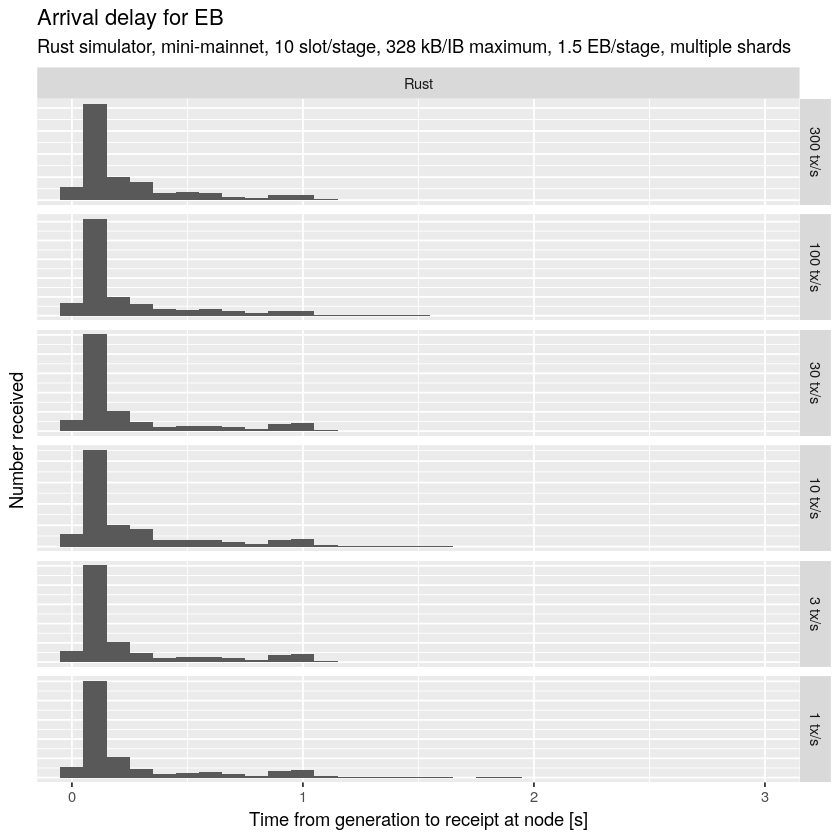

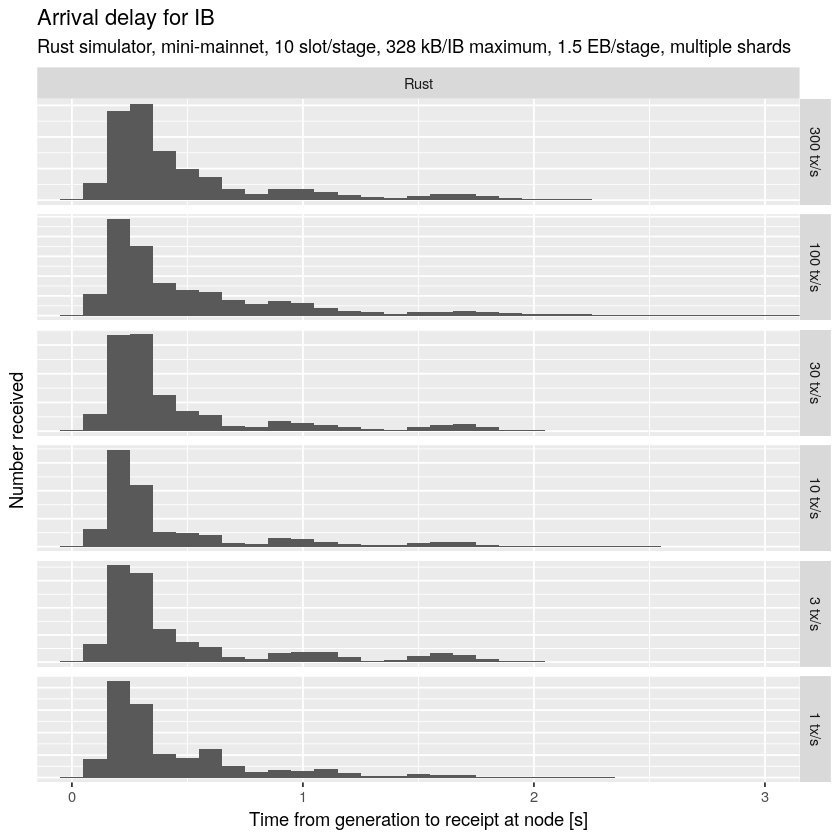

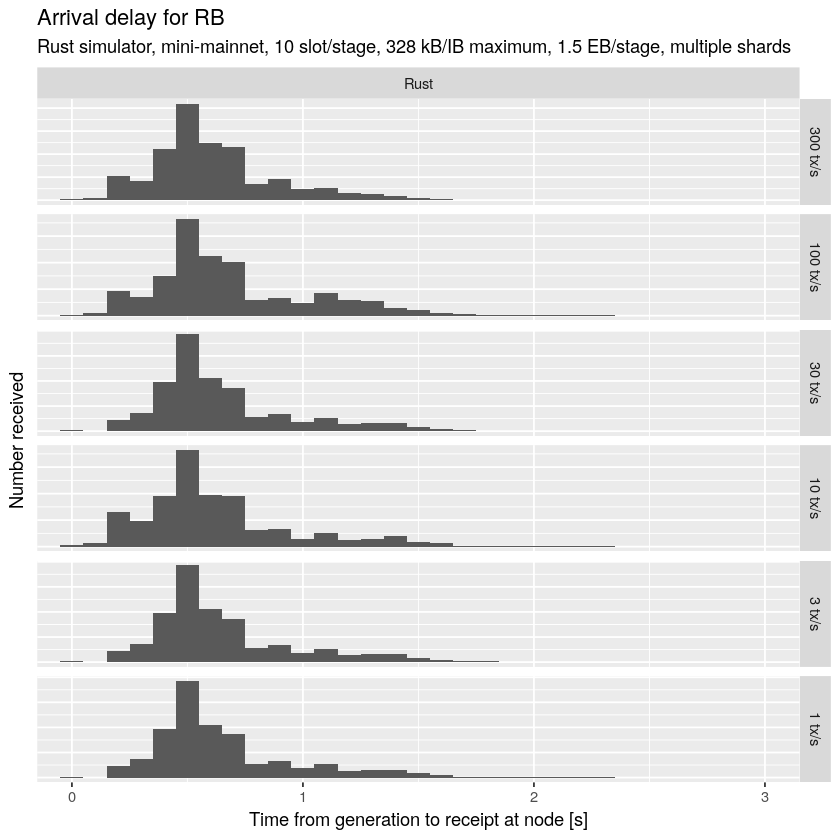

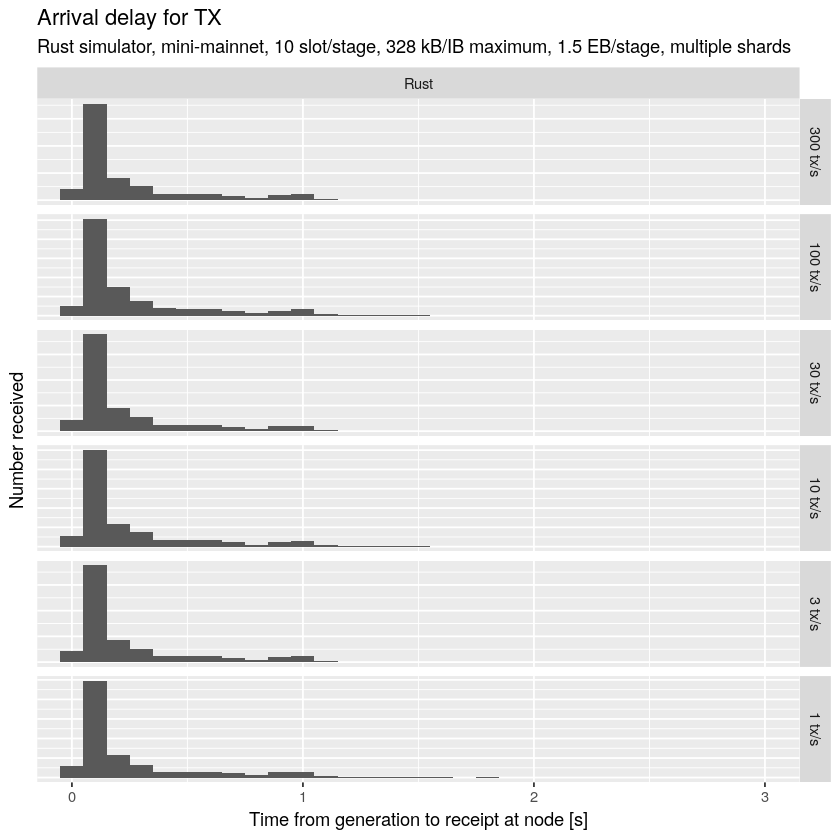

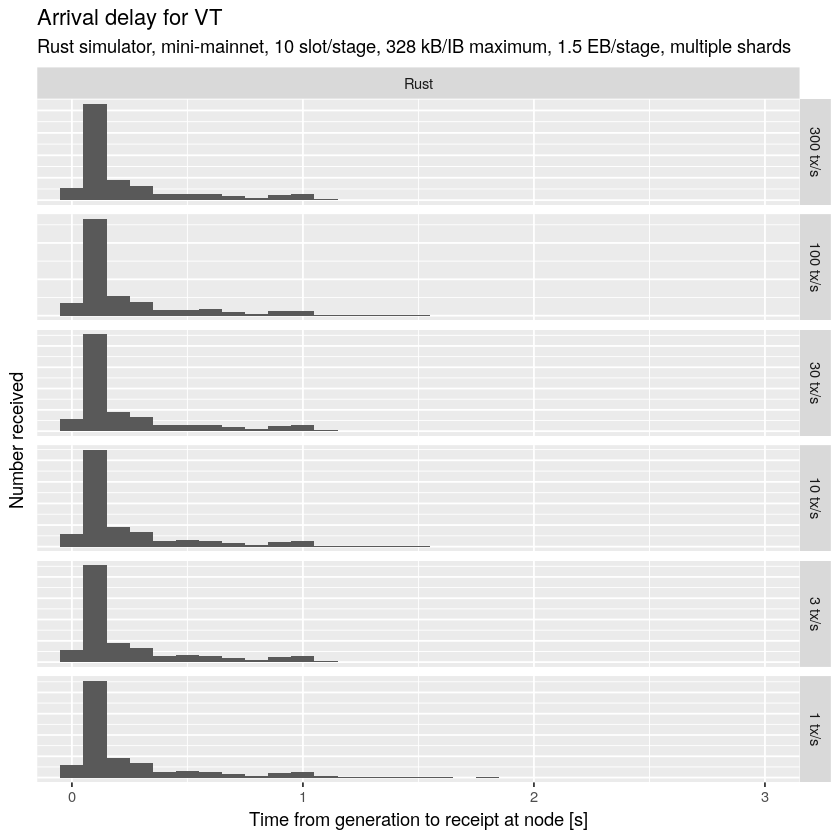

In [51]:
for (k in kinds)
    arrivalDelayHistogram(
        receipts[`Kind` == k],
        paste("Arrival delay for", k),
        scales="free_y",
        outfiles=paste0("plots/tps/elapsed-", k, ".png")
    ) %>% print

#### Fraction of items arriving

In [52]:
arrivalFractionTimeseries <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Received`=as.numeric(.N)),
            by=.(`Simulator`, `TPS`, `Generated [s]`, `Item`)
        ][,
            .(`Total`=as.numeric(.N), `Received`=sum(`Received`)),
            by=.(`Simulator`, `TPS`, `Generated [s]`)
        ][,
            .(`Received`=sum(`Received`)/sum(`Total`)),
            by=.(`Simulator`, `TPS`, `Generated [s]`)
        ][, .(
                `Simulator`,
                `TPS`=tpsFactor(`TPS`),
                `Generated [s]`,
                `Received`
        )], 
        aes(x=`Generated [s]`, y=`Received`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`TPS`  ~ `Simulator`, scales=scales) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

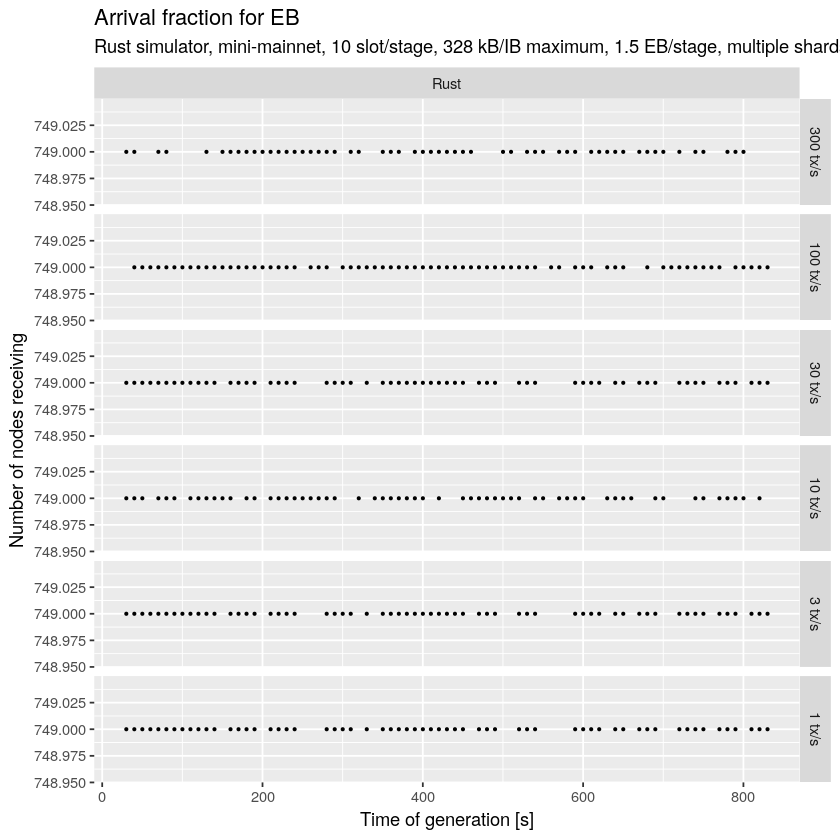

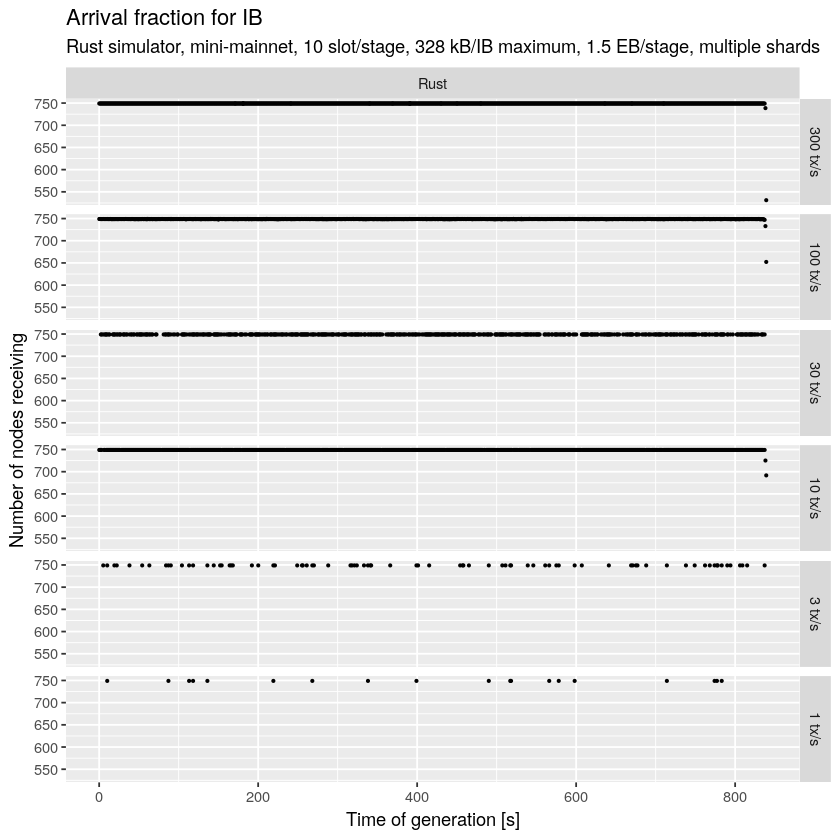

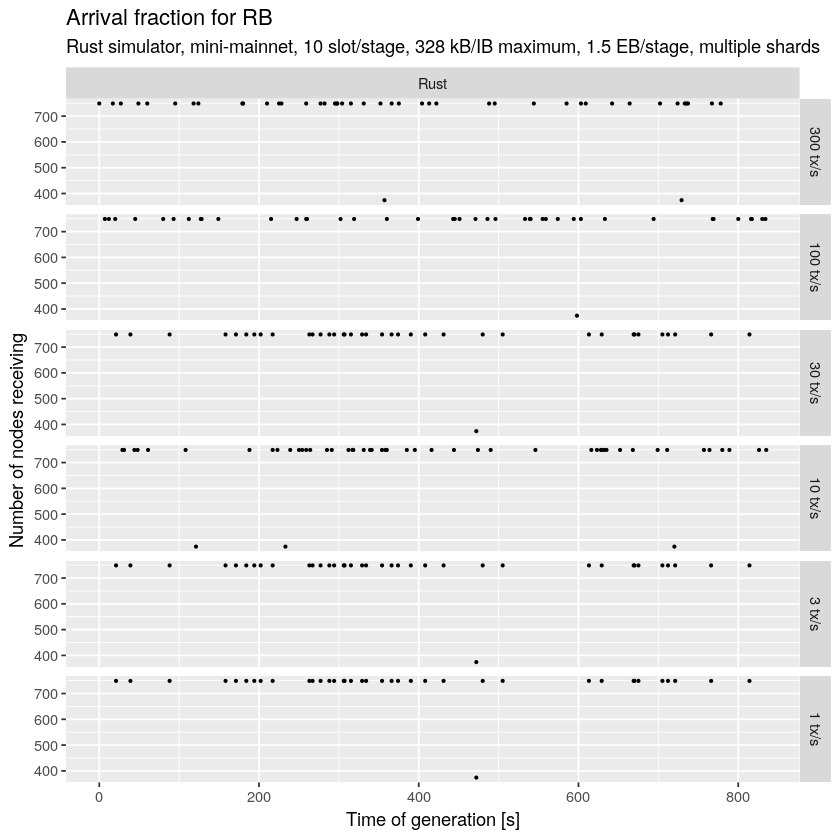

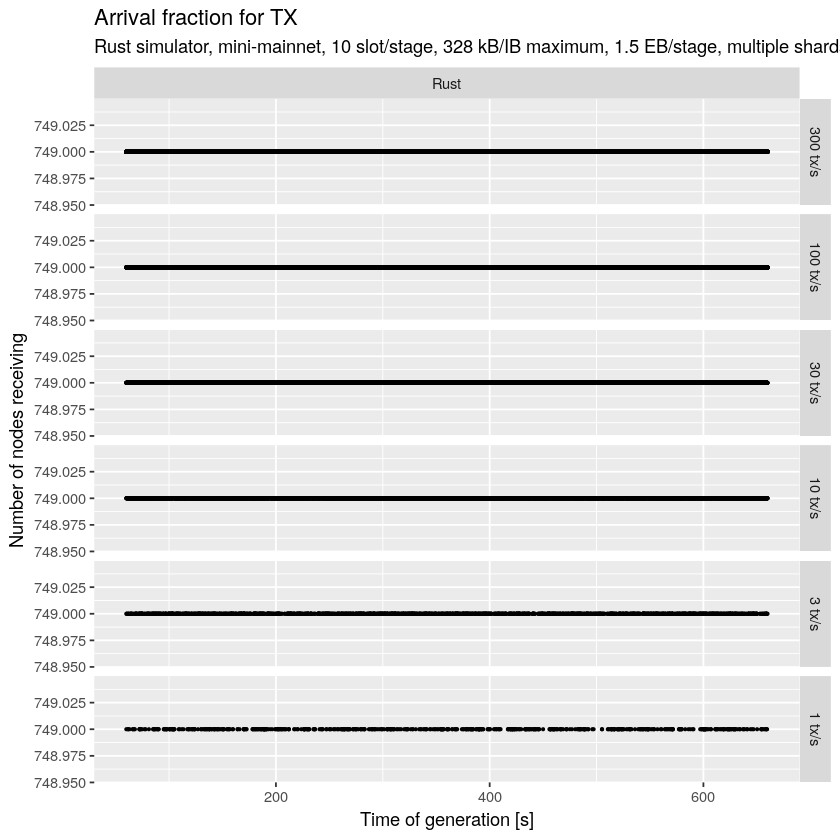

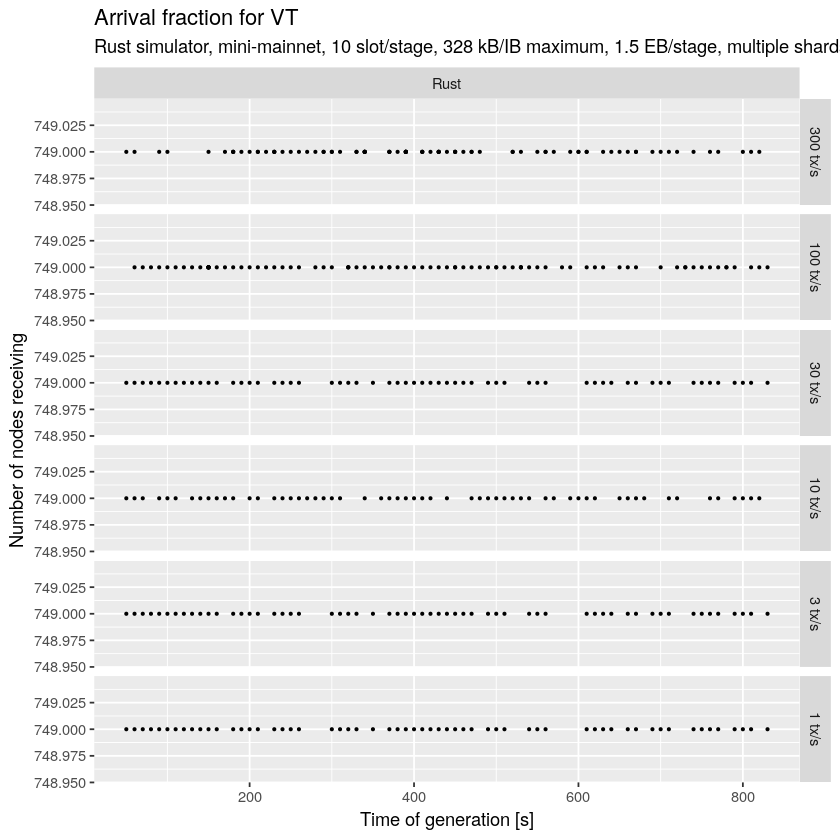

In [53]:
for (k in kinds)
    arrivalFractionTimeseries(
        receipts[`Kind` == k],
        paste("Arrival fraction for", k),
        outfiles=paste0("plots/tps/arrival-", k, ".png")
    ) %>% print

#### Bandwidth usage

##### Total network bandwidth

In [ ]:
totalBandwidthPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [GB]`=sum(`Size [B]`, rm.na=TRUE)/1e9
            ),
            by=.(
                `Simulator`,
                `TPS`=tpsFactor(`TPS`),
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`
            )
        ],
        aes(x=`Slot`, y=`Size [GB]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`TPS` ~ `Simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Total network ingress [GB/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

In [ ]:
totalBandwidthPlot(
    receipts,
    "Total bandwidth",
    outfiles=paste0("plots/tps/ingress-total-area.png")
)

##### Bandwidth usage per node

In [54]:
nodeCount <- receipts[, length(unique(`Recipient`))]
nodeCount

[1] 750

In [ ]:
meanNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [MB/node]`=sum(`Size [B]`)/1e6 / nodeCount
            ),
            by=.(
                `Simulator`,
                `TPS`=tpsFactor(`TPS`),
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`
            )
        ],
        aes(x=`Slot`, y=`Size [MB/node]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`TPS` ~ `Simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [MB/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

In [ ]:
meanNodalIngressPlot(
    receipts, 
    "Mean nodal ingress",
    outfiles=paste0("plots/tps/ingress-average-area.png")
)

In [ ]:
peakNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [MB]`=sum(`Size [B]`, rm.na=TRUE)/1e6
            ),
            by=.(
                `Simulator`,
                `TPS`=tpsFactor(`TPS`),
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`,
                `Recipient`
            )
        ][,
            .(`Size [MB]`=max(`Size [MB]`)),
            by=.(`Simulator`, `TPS`, `Slot`, `Message`)
        ],
        aes(x=`Slot`, y=`Size [MB]`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`TPS` ~ `Simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [MB/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

In [ ]:
peakNodalIngressPlot(
    receipts, 
    "Peak nodal ingress",
    outfiles=paste0("plots/tps/ingress-peak-point.png")
)

#### Release memory

In [55]:
rm(receipts)

### CPU usage

#### Read results

In [56]:
cpus <- fread("results/tps/cpus.csv.gz", stringsAsFactors=TRUE)
cpus %>% summary

 Simulator             TPS             Slot             Node          
 Rust:395144075   Min.   :  1.0   Min.   :  0.0   node-363:   526990  
                  1st Qu.:100.0   1st Qu.:217.0   node-652:   526984  
                  Median :100.0   Median :387.0   node-653:   526982  
                  Mean   :179.2   Mean   :387.9   node-331:   526977  
                  3rd Qu.:300.0   3rd Qu.:548.0   node-395:   526977  
                  Max.   :300.0   Max.   :840.0   node-693:   526976  
                                                  (Other) :391982189  
      Task            Duration [s]     
 ValTX  :239148210   Min.   :0.000164  
 ValVote: 99777286   1st Qu.:0.000816  
 ValIH  : 27662812   Median :0.001500  
 ValIB  : 27655255   Mean   :0.005321  
 ValEB  :   540029   3rd Qu.:0.001500  
 ValRB  :   188739   Max.   :0.213839  
 (Other):   171744                     

In [57]:
cpusNode <-
cpus[
    ,
    .(
        `Duration [s]`=sum(`Duration [s]`)
    ),
    by=.(
        `Simulator`,
        `TPS`=tpsFactor(`TPS`),
        `Node`,
        `Slot`
    )
]

#### Peak CPU usage

##### Histogram

In [58]:
peakCpuHistogram <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*max(`Duration [s]`)
            ),
            by=.(
                `Simulator`,
                `TPS`,
                `Slot`
            )
        ], 
        aes(x=`Duration [%]`)
    ) +
        geom_histogram(binwidth=10) +
        facet_grid(`TPS` ~ `Simulator`, scales=scales) +
      # coord_cartesian(xlim=c(0, 700)) +
        xlab("Peak CPU load [%]") +
        ylab("Number of slots") +
        ggtitle(title, subtitle="label")
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

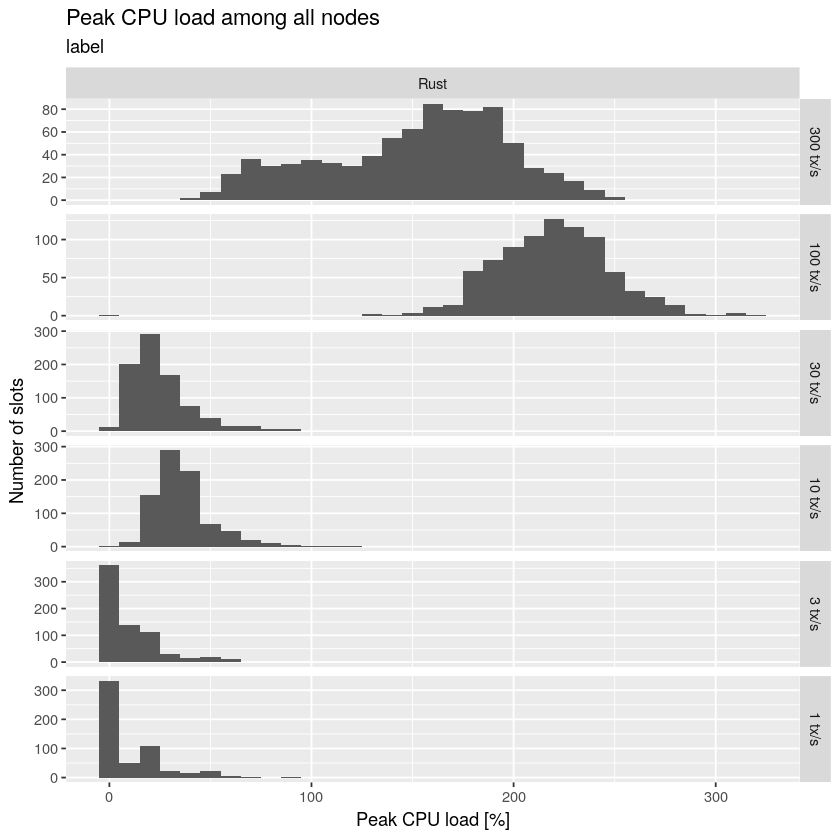

In [59]:
peakCpuHistogram(
    cpusNode, 
    "Peak CPU load among all nodes",
    scales="free_y",
    outfiles=paste0("plots/tps/cpu-peak-histogram.png")
)

##### Time series

In [60]:
peakCpuTimeseries <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*mean(`Duration [s]`)
            ),
            by=.(
                `Simulator`,
                `TPS`,
                `Slot`
            )
        ], 
        aes(x=`Slot`, y=`Duration [%]`)) +
        geom_line() +
        facet_grid(`TPS` ~ `Simulator`, scale=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

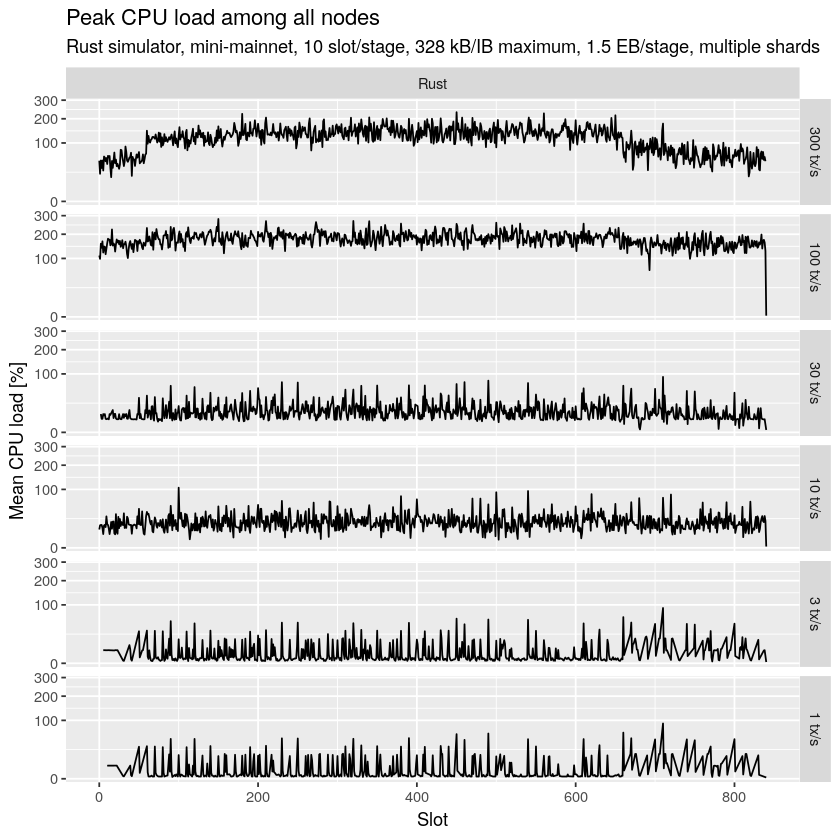

In [61]:
peakCpuTimeseries(
    cpusNode,
    "Peak CPU load among all nodes",
    outfiles=paste0("plots/tps/cpu-peak-timeseries.png")
)

#### Mean CPU usage

##### Histogram

In [62]:
meanCpuHistogram <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds
            ),
            by=.(
                `Simulator`,
                `TPS`=tpsFactor(`TPS`),
                `Task`
            )
        ], 
        aes(x="", fill=`Task`, y=`Duration [%]`)) +
        geom_bar(stat = "identity") +
        facet_grid(`TPS` ~ `Simulator`, scales=scales) +
        xlab("") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

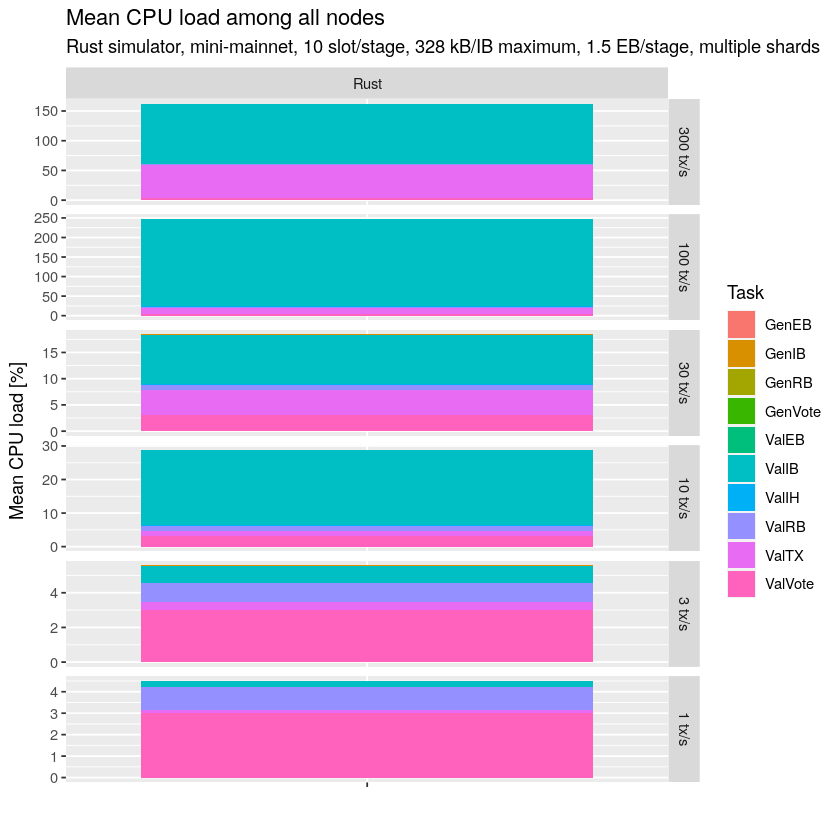

In [63]:
meanCpuHistogram(
    cpus,
    nodeCount * txWindow, 
    "Mean CPU load among all nodes", 
    scales="free_y",
    outfiles=paste0("plots/tps/cpu-mean-histogram.png")
)

##### Time series

In [64]:
meanCpuTimeseries <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds
            ),
            by=.(
                `Simulator`,
                `TPS`=tpsFactor(`TPS`),
                `Slot`,
                `Task`
            )
        ], 
        aes(x=`Slot`, y=`Duration [%]`, color=`Task`)
    ) +
        geom_point(size=0.25, alpha=0.75) +
        facet_grid(`TPS` ~ `Simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

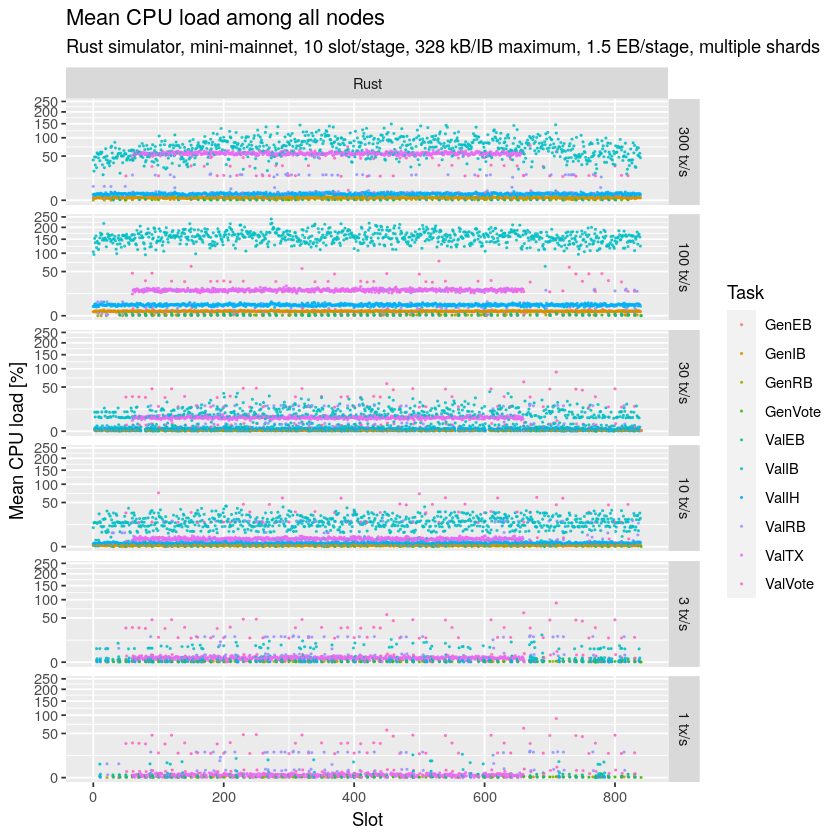

In [65]:
meanCpuTimeseries(
    cpus, 
    nodeCount, 
    "Mean CPU load among all nodes",
    outfiles=paste0("plots/tps/cpu-mean-timeseries.png")
)

#### Release memory

In [66]:
rm(cpus, cpusNode)

## IB Experiment

In [67]:
label <- "mini-mainnet, 10 slot/stage, 328 kB/IB maximum, 1.5 EB/stage, multiple shards"

### Resource usage

In [68]:
resources <- fread("results/ibs/resources.csv.gz", stringsAsFactors=TRUE)
resources %>% summary

   Simulator         IBPS              Node         Egress [B]
 Haskell:5250   Min.   : 0.500   node-0  :   14   Min.   :0   
 Rust   :5250   1st Qu.: 1.000   node-1  :   14   1st Qu.:0   
                Median : 4.000   node-10 :   14   Median :0   
                Mean   : 9.071   node-100:   14   Mean   :0   
                3rd Qu.:16.000   node-101:   14   3rd Qu.:0   
                Max.   :32.000   node-102:   14   Max.   :0   
                                 (Other) :10416               
    Disk [B]        Total CPU [s]     Maximum CPU [s/s]
 Min.   :       0   Min.   :  11.61   Min.   :0.6358   
 1st Qu.:       0   1st Qu.:  68.64   1st Qu.:1.2436   
 Median :       0   Median : 188.33   Median :1.9989   
 Mean   :  705712   Mean   : 371.52   Mean   :2.4143   
 3rd Qu.:    8768   3rd Qu.: 599.59   3rd Qu.:2.9151   
 Max.   :14965312   Max.   :1415.03   Max.   :6.3794   
                                                       

In [ ]:
ggplot(
    resources[, .(`Simulator`, `IB/S`=factor(`IBPS`), `Node`, `Nodal egress [MB/s]`=`Egress [B]`/600/1e6)], 
    aes(x=`IB/S`, y=`Nodal egress [MB/s]`)
) +
    geom_violin() +
    facet_grid(`Simulator` ~ .) +
    ggtitle("Network", label)

In [ ]:
ggsave("plots/ibs/network.png", units="in", dpi=150, width=9.5, height=5.5)

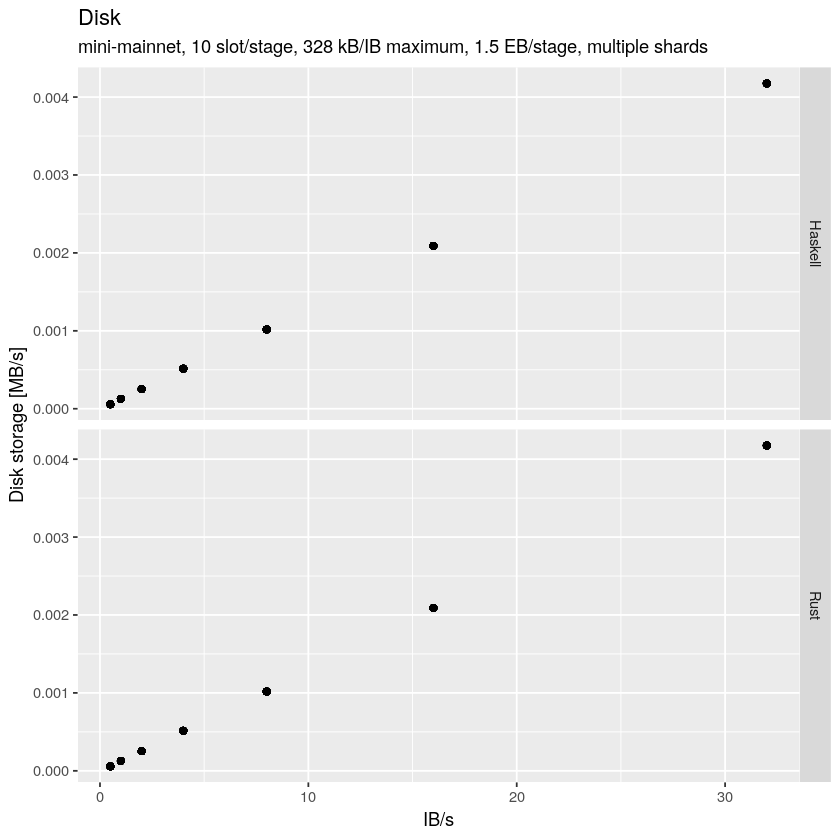

In [70]:
ggplot(
    resources[, .(`Simulator`, `Disk storage [MB/s]`=mean(`Disk [B]`)/txWindow/1e6), .(`IB/s`=`IBPS`)],
    aes(x=`IB/s`, y=`Disk storage [MB/s]`)
) +
    geom_point() +
    facet_grid(`Simulator` ~ .) +
    ggtitle("Disk", label)

In [71]:
ggsave("plots/ibs/disk.png", units="in", dpi=150, width=9.5, height=5.5)

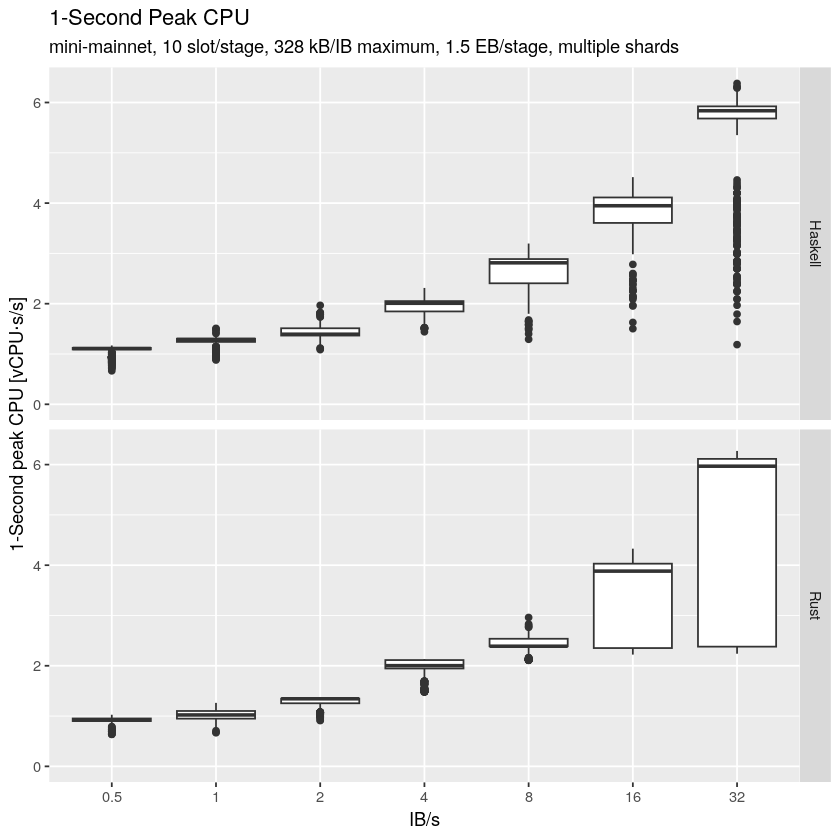

In [72]:
ggplot(
    resources[, .(`Simulator`, `Node`, `IB/s`=factor(`IBPS`), `1-Second peak CPU [vCPU⋅s/s]`=`Maximum CPU [s/s]`)], 
    aes(x=`IB/s`, y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_grid(`Simulator` ~ .) +
    ggtitle("1-Second Peak CPU", label)

In [73]:
ggsave("plots/ibs/cpu-peak.png", units="in", dpi=150, width=9.5, height=5.5)

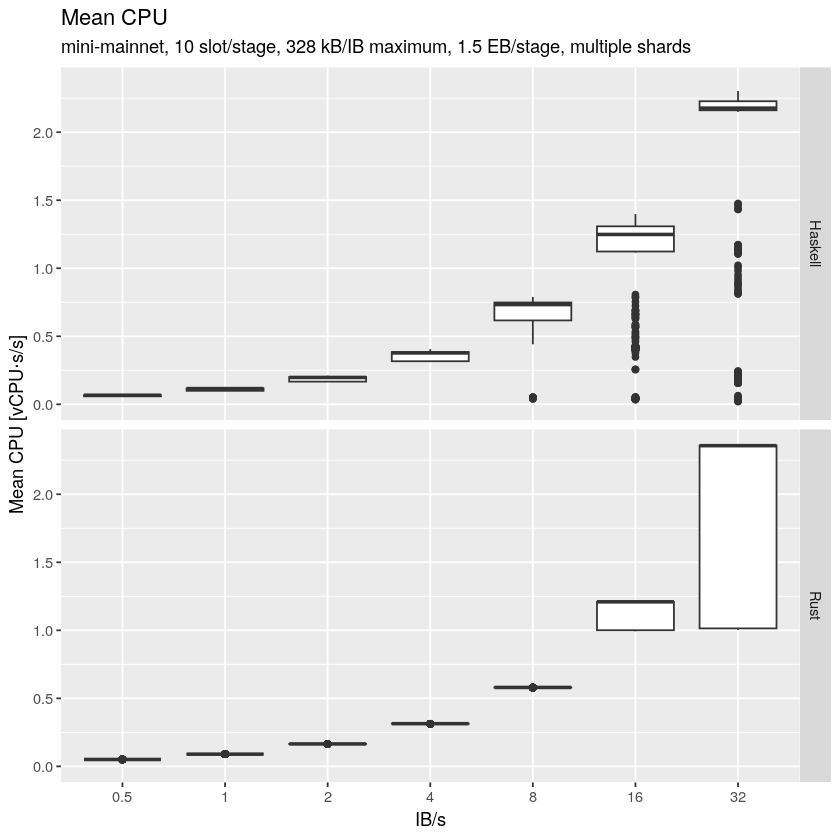

In [74]:
ggplot(
    resources[, .(`Simulator`, `IB/s`=factor(`IBPS`), `Node`, `Mean CPU [vCPU⋅s/s]`=`Total CPU [s]`/txWindow
        )
    ], aes(x=`IB/s`, y=`Mean CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_grid(`Simulator` ~ .) +
    ggtitle("Mean CPU", label)

In [75]:
ggsave("plots/ibs/cpu-mean.png", units="in", dpi=150, width=9.5, height=5.5)

#### Release memory

In [76]:
rm(resources)

### Receipt of messages

#### Read results

In [77]:
receipts <- fread("results/ibs/receipts.csv.gz", stringsAsFactors=TRUE)
receipts %>% summary

   Simulator             IBPS       Kind                    Item         
 Haskell:38584750   Min.   : 0.50   EB:  778211   100-node-58 :    5992  
 Rust   :30321006   1st Qu.: 2.00   IB:24529477   200-node-557:    5992  
                    Median : 8.00   RB:  152323   220-node-150:    5992  
                    Mean   :11.66   VT:43445745   230-node-15 :    5992  
                    3rd Qu.:16.00                 50-node-606 :    5992  
                    Max.   :32.00                 60-node-560 :    5992  
                                                  (Other)     :68869804  
     Producer        Generated [s]        Recipient         Received [s]      
 node-49 :  394334   Min.   :  0.001   node-676:   95576   Min.   :  0.00125  
 node-96 :  387420   1st Qu.: 90.000   node-311:   95575   1st Qu.: 90.90714  
 node-529:  387252   Median :160.001   node-492:   95572   Median :160.36030  
 node-415:  386517   Mean   :160.616   node-123:   95569   Mean   :161.08881  
 node-18 :  3

In [78]:
ibpsLevels <- paste(receipts[, sort(unique(`IBPS`), decreasing=TRUE)], "IB/s")
ibpsFactor <- function(ibps) factor(paste(ibps, "IB/s"), levels=ibpsLevels)

In [79]:
kinds <- receipts[, unique(`Kind`) %>% sort]
kinds

[1] EB IB RB VT
Levels: EB IB RB VT

#### Arrival histograms

##### Compare the distributions of elapsed times

In [80]:
arrivalDelayHistogram <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[, .(`Simulator`, `IB/s`=ibpsFactor(`IBPS`), `Elapsed [s]`)],
        aes(x=`Elapsed [s]`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_grid(`IB/s` ~ `Simulator`, scales=scales) +
        coord_cartesian(xlim=c(0, 3)) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(title, subtitle=label) +
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

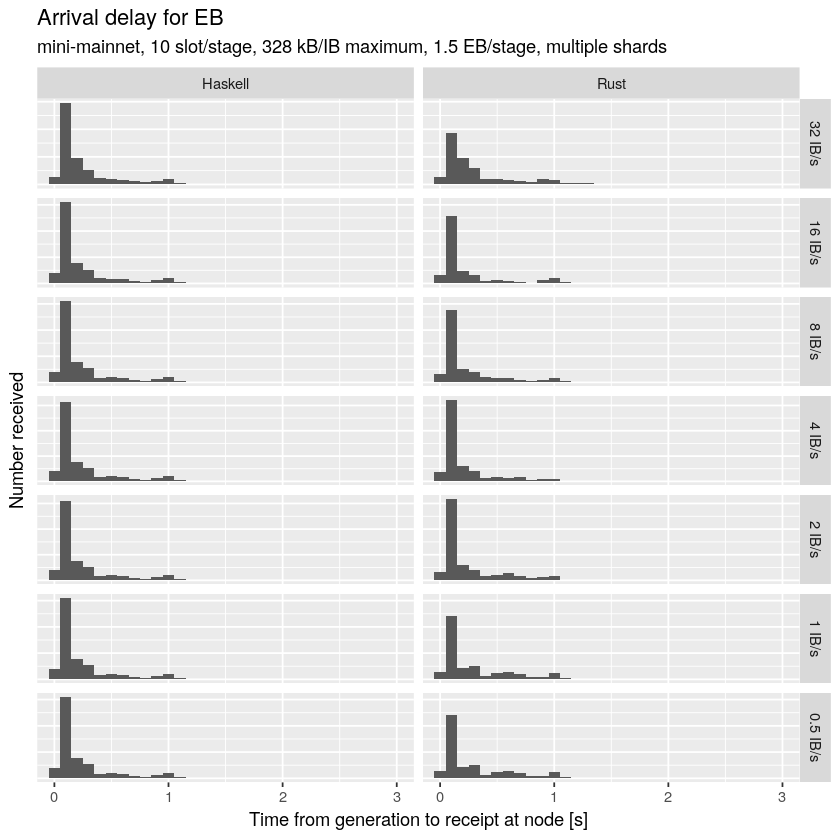

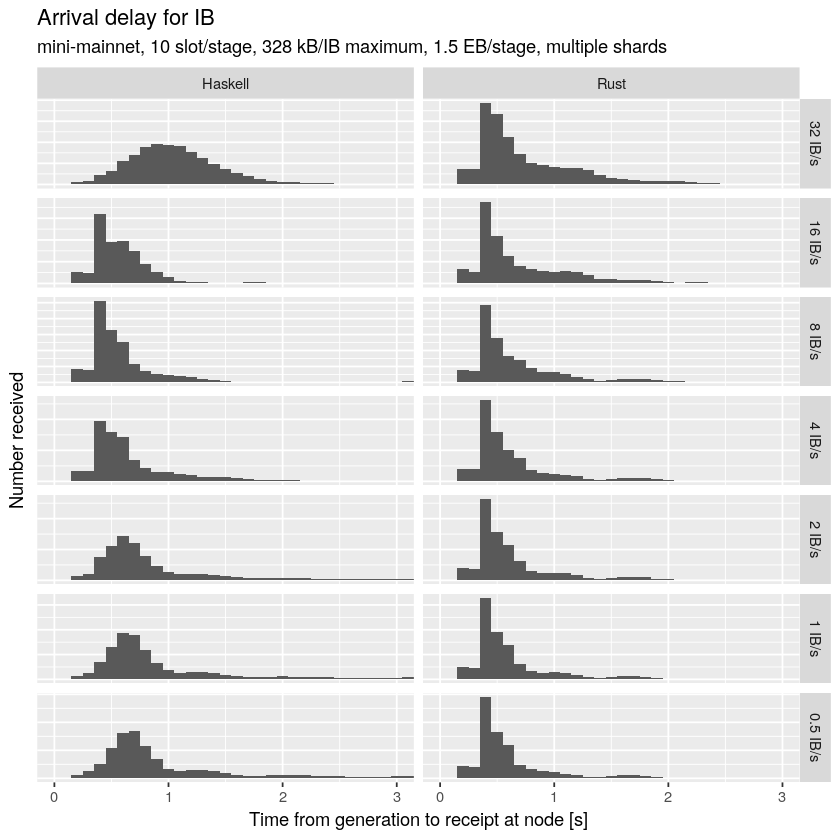

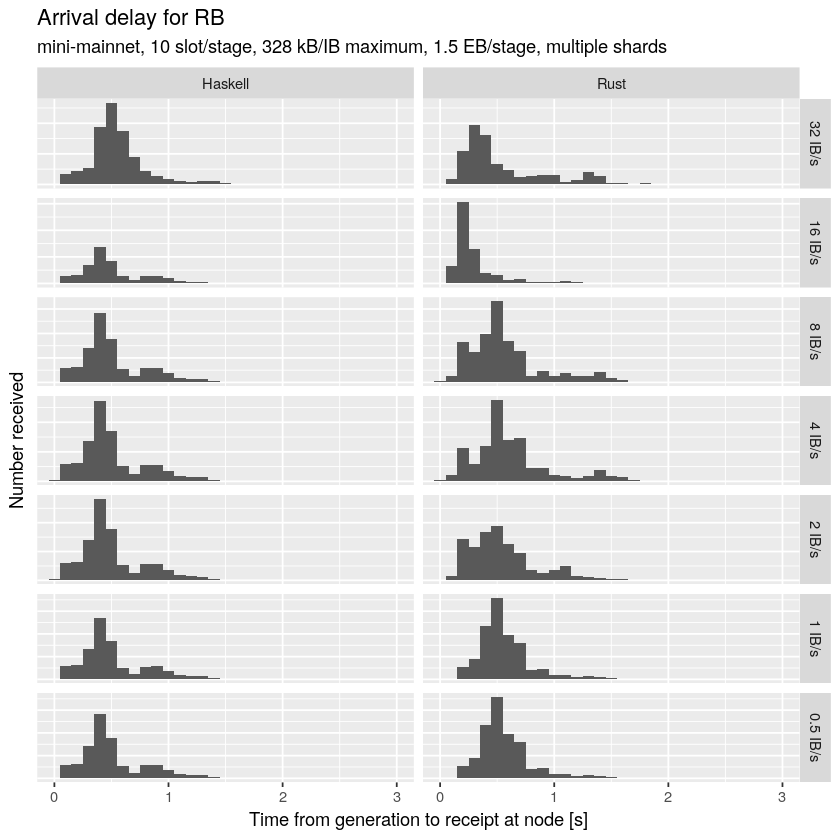

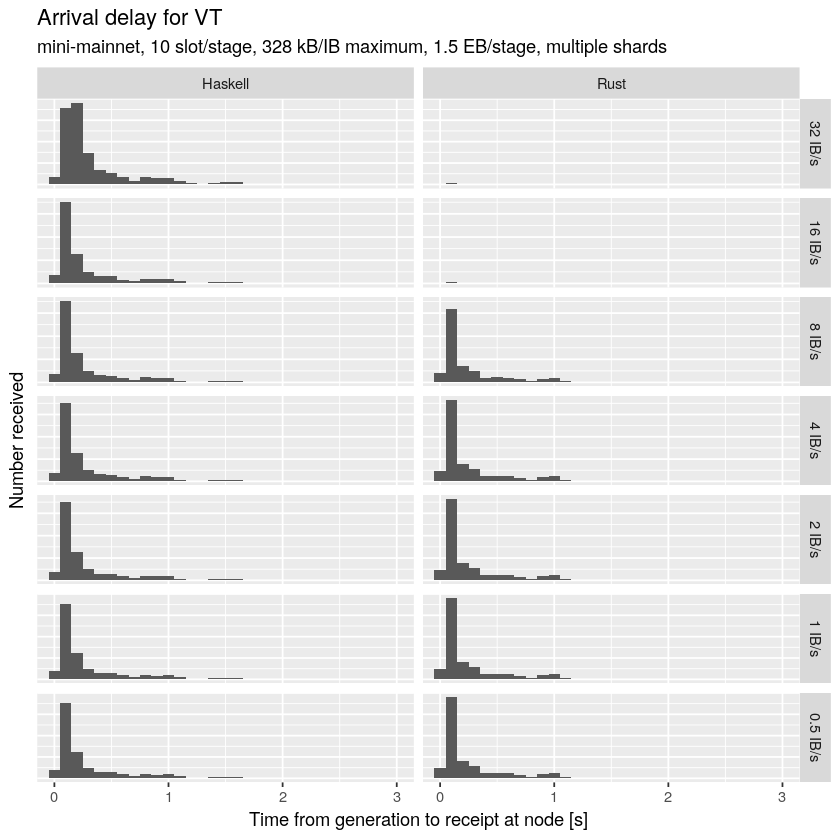

In [81]:
for (k in kinds)
    arrivalDelayHistogram(
        receipts[`Kind` == k],
        paste("Arrival delay for", k),
        scales="free_y",
        outfiles=paste0("plots/ibs/elapsed-", k, ".png")
    ) %>% print

#### Fraction of items arriving

In [82]:
arrivalFractionTimeseries <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Received`=as.numeric(.N)),
            by=.(`Simulator`, `IBPS`, `Generated [s]`, `Item`)
        ][,
            .(`Total`=as.numeric(.N), `Received`=sum(`Received`)),
            by=.(`Simulator`, `IBPS`, `Generated [s]`)
        ][,
            .(`Received`=sum(`Received`)/sum(`Total`)),
            by=.(`Simulator`, `IBPS`, `Generated [s]`)
        ][, .(
                `Simulator`,
                `IB/s`=ibpsFactor(`IBPS`),
                `Generated [s]`,
                `Received`
        )], 
        aes(x=`Generated [s]`, y=`Received`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`IB/s`  ~ `Simulator`, scales=scales) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

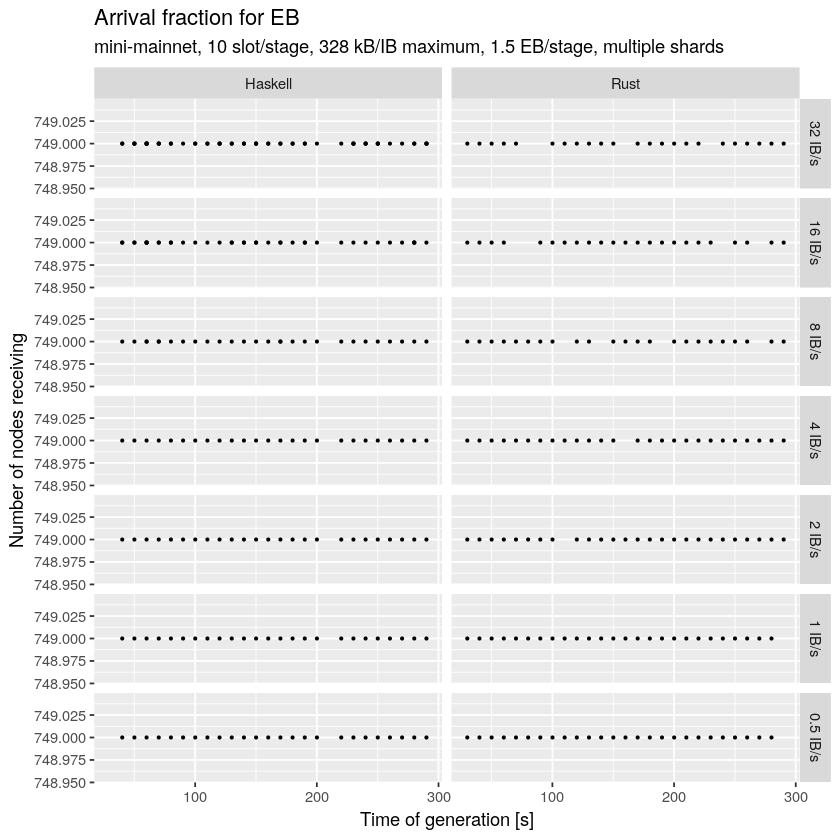

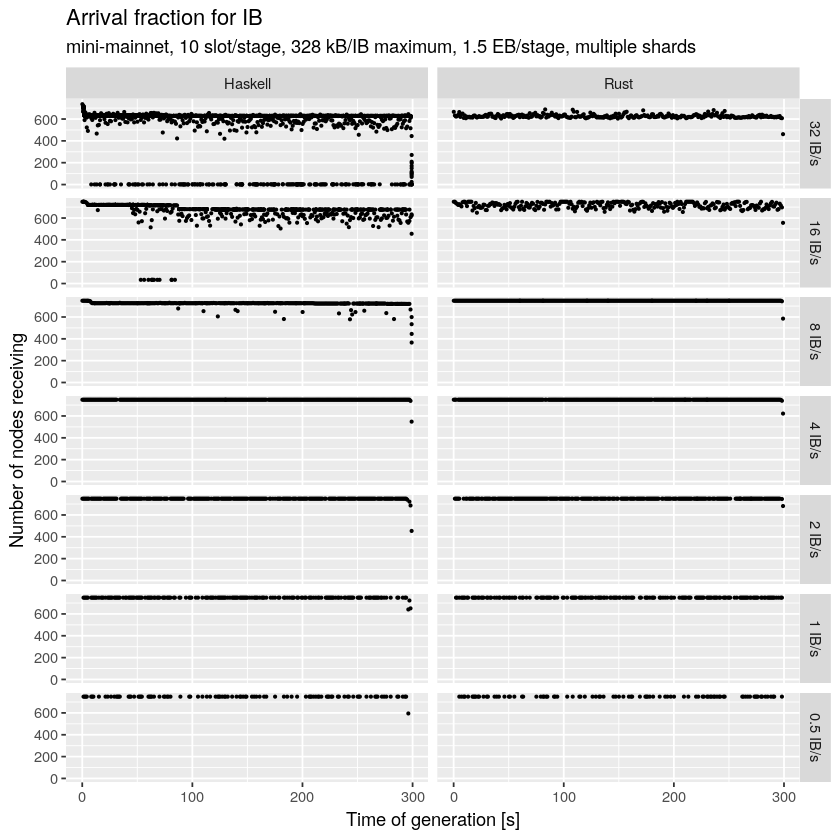

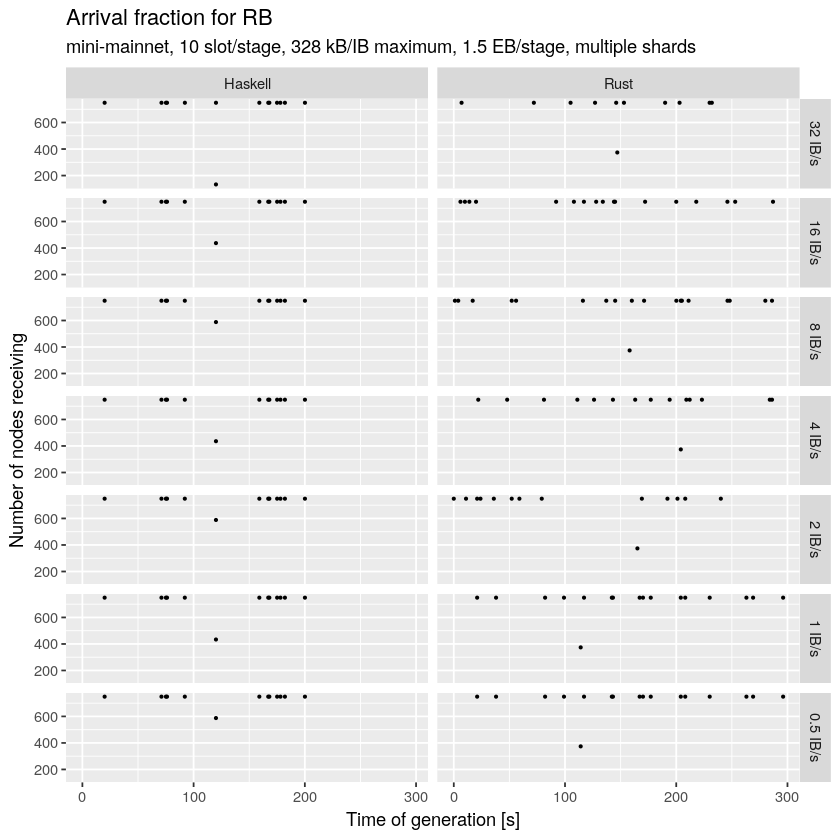

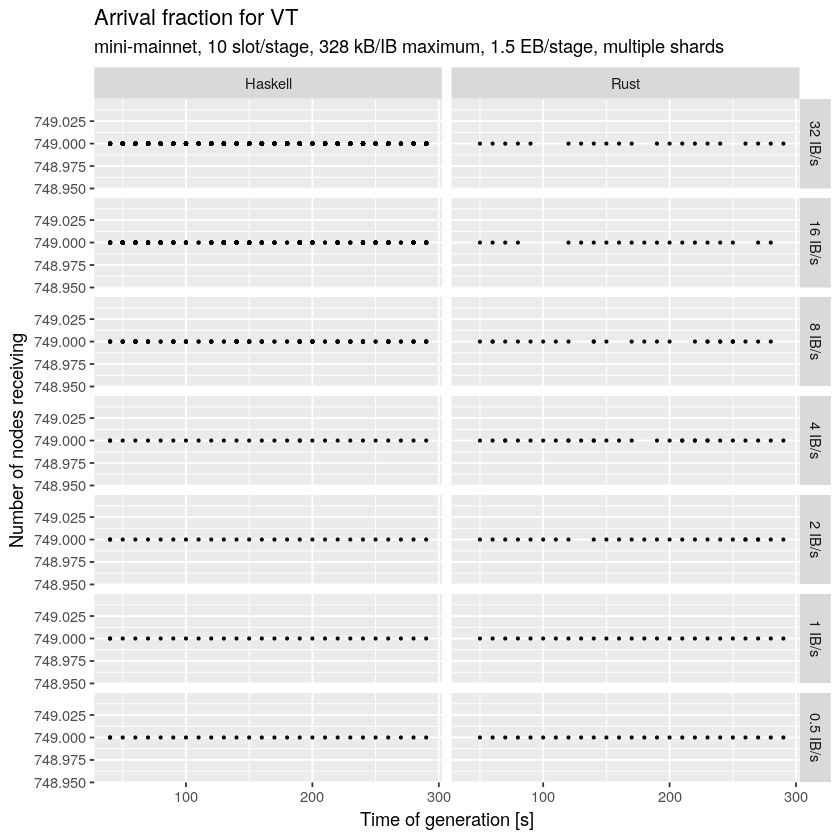

In [83]:
for (k in kinds)
    arrivalFractionTimeseries(
        receipts[`Kind` == k],
        paste("Arrival fraction for", k),
        outfiles=paste0("plots/ibs/arrival-", k, ".png")
    ) %>% print

#### Bandwidth usage

##### Total network bandwidth

In [ ]:
totalBandwidthPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [GB]`=sum(`Size [B]`, rm.na=TRUE)/1000000000
            ),
            by=.(
                `Simulator`,
                `IB/s`=ibpsFactor(`IBPS`),
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`
            )
        ],
        aes(x=`Slot`, y=`Size [GB]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`IB/s` ~ `Simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Total network ingress [GB/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

In [ ]:
totalBandwidthPlot(
    receipts,
    "Total bandwidth",
    outfiles=paste0("plots/ibs/ingress-total-area.png")
)

##### Bandwidth usage per node

In [ ]:
meanNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [MB/node]`=sum(`Size [B]`)/1000000 / nodeCount
            ),
            by=.(
                `Simulator`,
                `IB/s`=ibpsFactor(`IBPS`),
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`
            )
        ],
        aes(x=`Slot`, y=`Size [MB/node]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`IB/s` ~ `Simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [MB/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

In [ ]:
meanNodalIngressPlot(
    receipts, 
    "Mean nodal ingress",
    outfiles=paste0("plots/ibs/ingress-average-area.png")
)

In [ ]:
peakNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(
                `Size [MB]`=sum(`Size [B]`, rm.na=TRUE)/1000000
            ),
            by=.(
                `Simulator`,
                `IB/s`=ibpsFactor(`IBPS`),
                `Slot`=floor(`Received [s]`),
                `Message`=`Kind`,
                `Recipient`
            )
        ][,
            .(`Size [MB]`=max(`Size [MB]`)),
            by=.(`Simulator`, `IB/s`, `Slot`, `Message`)
        ],
        aes(x=`Slot`, y=`Size [MB]`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`IB/s` ~ `Simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [MB/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

In [ ]:
peakNodalIngressPlot(
    receipts, 
    "Peak nodal ingress",
    outfiles=paste0("plots/ibs/ingress-peak-point.png")
)

#### Release memory

In [84]:
rm(receipts)

### CPU usage

#### Read results

In [85]:
cpus <- fread("results/ibs/cpus.csv.gz", stringsAsFactors=TRUE)
cpus %>% summary

   Simulator              IBPS            Slot             Node          
 Haskell:202193070   Min.   : 0.50   Min.   :  0.0   node-242:   622654  
 Rust   : 74459675   1st Qu.: 4.00   1st Qu.: 80.0   node-107:   603776  
                     Median : 8.00   Median :151.0   node-505:   587773  
                     Mean   :12.03   Mean   :151.5   node-241:   581620  
                     3rd Qu.:16.00   3rd Qu.:224.0   node-400:   579421  
                     Max.   :32.00   Max.   :300.0   node-8  :   575427  
                                                     (Other) :273102074  
      Task            Duration [s]   
 ValIH  :176047092   Min.   :0.0000  
 ValVote: 73485888   1st Qu.:0.0010  
 ValIB  : 24285787   Median :0.0010  
 ValRH  :  1765005   Mean   :0.0141  
 ValEB  :   778211   3rd Qu.:0.0010  
 ValRB  :   152323   Max.   :0.1810  
 (Other):   138439                   

In [86]:
cpusNode <-
cpus[
    ,
    .(
        `Duration [s]`=sum(`Duration [s]`)
    ),
    by=.(
        `Simulator`,
        `IB/s`=ibpsFactor(`IBPS`),
        `Node`,
        `Slot`
    )
]

#### Peak CPU usage

##### Histogram

In [87]:
peakCpuHistogram <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*max(`Duration [s]`)
            ),
            by=.(
                `Simulator`,
                `IB/s`,
                `Slot`
            )
        ], 
        aes(x=`Duration [%]`)
    ) +
        geom_histogram(binwidth=10) +
        facet_grid(`IB/s` ~ `Simulator`, scales=scales) +
      # coord_cartesian(xlim=c(0, 700)) +
        xlab("Peak CPU load [%]") +
        ylab("Number of slots") +
        ggtitle(title, subtitle="label")
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

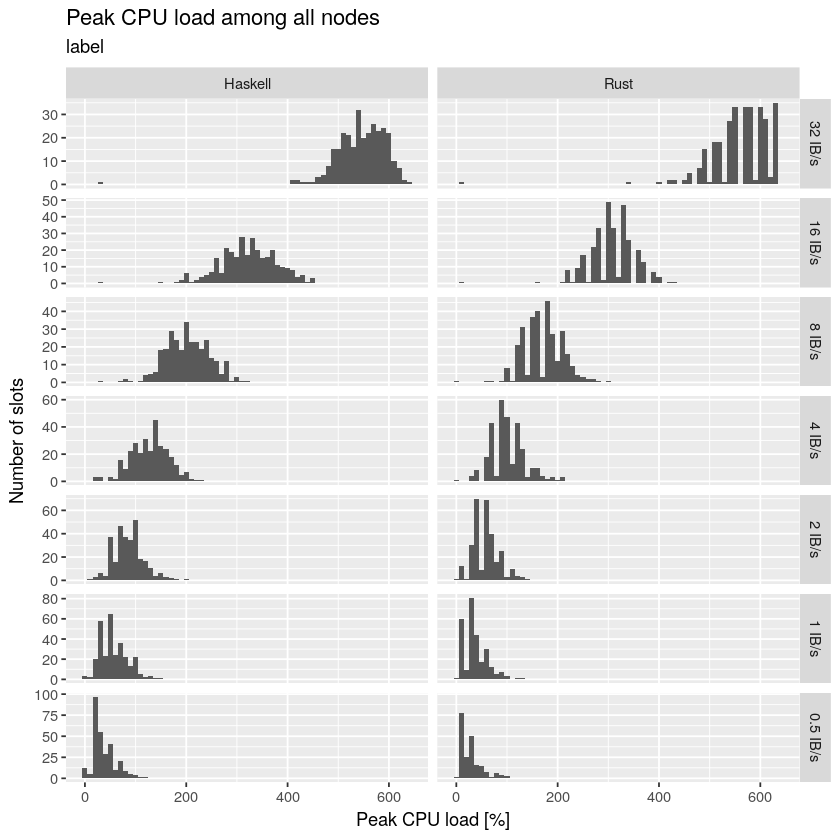

In [88]:
peakCpuHistogram(
    cpusNode, 
    "Peak CPU load among all nodes",
    scales="free_y",
    outfiles=paste0("plots/ibs/cpu-peak-histogram.png")
)

##### Time series

In [89]:
peakCpuTimeseries <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*mean(`Duration [s]`)
            ),
            by=.(
                `Simulator`,
                `IB/s`,
                `Slot`
            )
        ], 
        aes(x=`Slot`, y=`Duration [%]`)) +
        geom_line() +
        facet_grid(`IB/s` ~ `Simulator`, scale=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

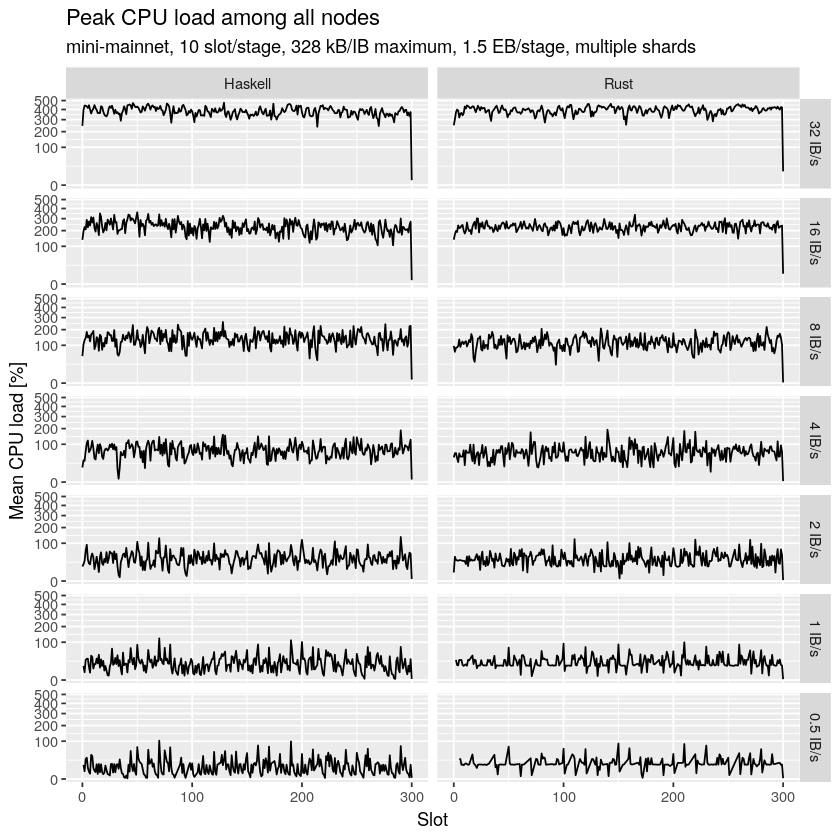

In [90]:
peakCpuTimeseries(
    cpusNode,
    "Peak CPU load among all nodes",
    outfiles=paste0("plots/ibs/cpu-peak-timeseries.png")
)

#### Mean CPU usage

##### Histogram

In [91]:
meanCpuHistogram <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds
            ),
            by=.(
                `Simulator`,
                `IB/s`=ibpsFactor(`IBPS`),
                `Task`
            )
        ], 
        aes(x="", fill=`Task`, y=`Duration [%]`)) +
        geom_bar(stat = "identity") +
        facet_grid(`IB/s` ~ `Simulator`, scales=scales) +
        xlab("") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

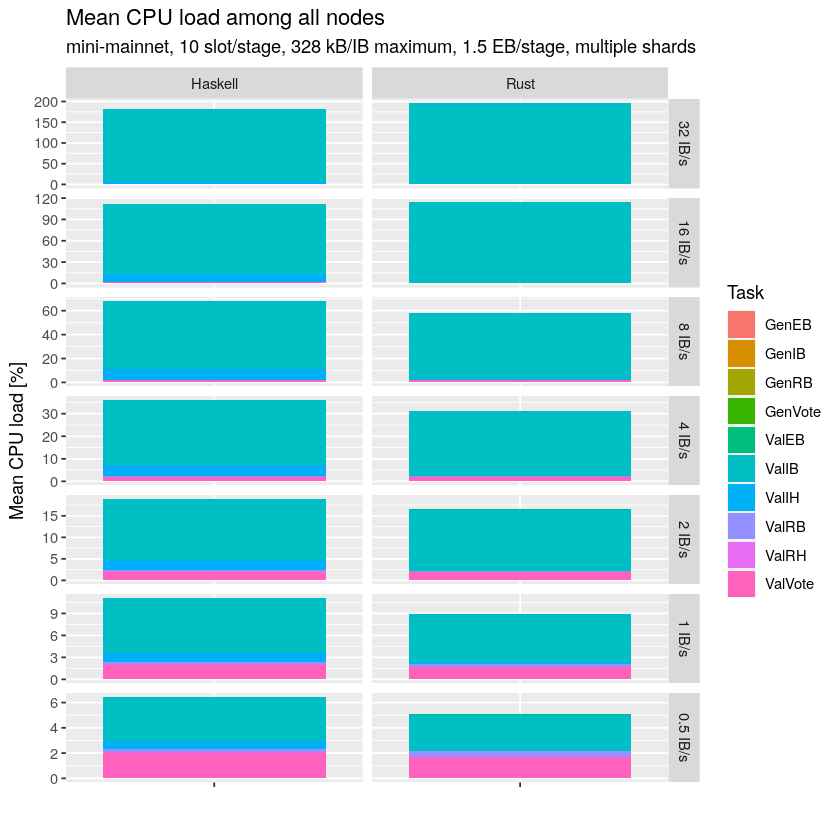

In [92]:
meanCpuHistogram(
    cpus,
    nodeCount * txWindow, 
    "Mean CPU load among all nodes", 
    scales="free_y",
    outfiles=paste0("plots/ibs/cpu-mean-histogram.png")
)

##### Time series

In [94]:
meanCpuTimeseries <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(
                `Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds
            ),
            by=.(
                `Simulator`,
                `IB/s`=ibpsFactor(`IBPS`),
                `Slot`,
                `Task`
            )
        ], 
        aes(x=`Slot`, y=`Duration [%]`, color=`Task`)
    ) +
        geom_point(size=0.25, alpha=0.75) +
        facet_grid(`IB/s` ~ `Simulator`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

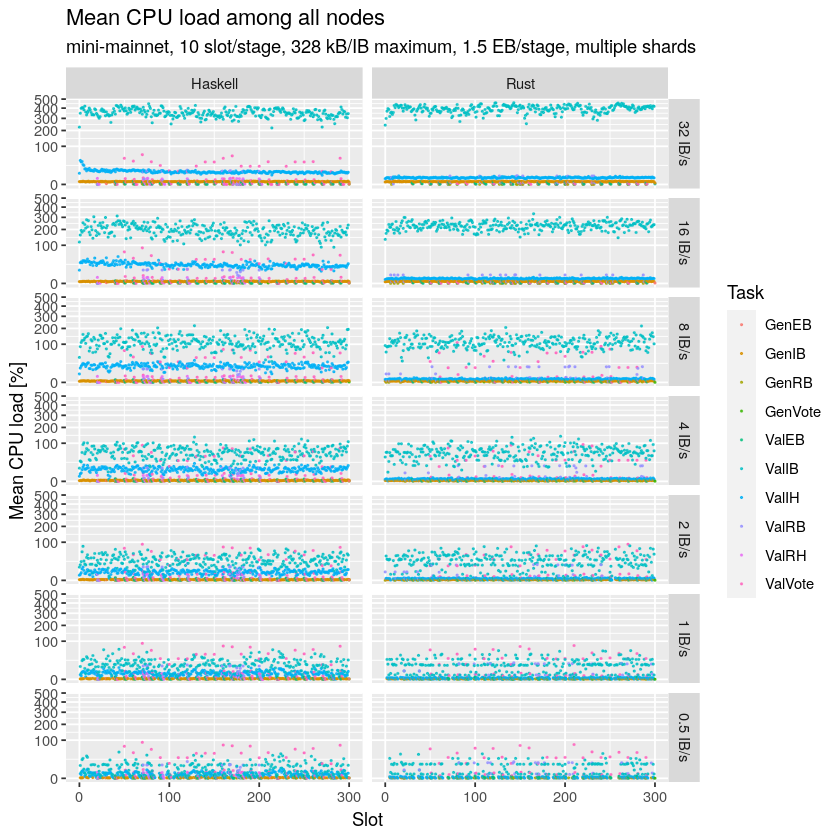

In [95]:
meanCpuTimeseries(
    cpus, 
    nodeCount, 
    "Mean CPU load among all nodes",
    outfiles=paste0("plots/ibs/cpu-mean-timeseries.png")
)

#### Release memory

In [96]:
rm(cpus, cpusNode)